In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM
from prophet import Prophet
from keras.models import Sequential

In [2]:
df = pd.read_table("household_power_consumption.txt", sep=";")

D:\Temp\ipykernel_22712\537563091.py:1: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_table("household_power_consumption.txt", sep=";")


In [3]:
df.head()

Date      Time Global_active_power Global_reactive_power  Voltage  \
0  16/12/2006  17:24:00               4.216                 0.418  234.840   
1  16/12/2006  17:25:00               5.360                 0.436  233.630   
2  16/12/2006  17:26:00               5.374                 0.498  233.290   
3  16/12/2006  17:27:00               5.388                 0.502  233.740   
4  16/12/2006  17:28:00               3.666                 0.528  235.680   

  Global_intensity Sub_metering_1 Sub_metering_2  Sub_metering_3  
0           18.400          0.000          1.000            17.0  
1           23.000          0.000          1.000            16.0  
2           23.000          0.000          2.000            17.0  
3           23.000          0.000          1.000            17.0  
4           15.800          0.000          1.000            17.0

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


# 1. Data Preprocessing:

In [5]:
df['Datetime'] = df['Date'] + ' ' + df['Time']

In [6]:
df

Date      Time Global_active_power Global_reactive_power  \
0        16/12/2006  17:24:00               4.216                 0.418   
1        16/12/2006  17:25:00               5.360                 0.436   
2        16/12/2006  17:26:00               5.374                 0.498   
3        16/12/2006  17:27:00               5.388                 0.502   
4        16/12/2006  17:28:00               3.666                 0.528   
...             ...       ...                 ...                   ...   
2075254  26/11/2010  20:58:00               0.946                   0.0   
2075255  26/11/2010  20:59:00               0.944                   0.0   
2075256  26/11/2010  21:00:00               0.938                   0.0   
2075257  26/11/2010  21:01:00               0.934                   0.0   
2075258  26/11/2010  21:02:00               0.932                   0.0   

         Voltage Global_intensity Sub_metering_1 Sub_metering_2  \
0        234.840           18.400          0.000          1.000   
1        233.630           23.000          0.000          1.000   
2        233.290           23.000          0.000          2.000   
3        233.740           23.000          0.000          1.000   
4        235.680           15.800          0.000          1.000   
...          ...              ...            ...            ...   
2075254   240.43              4.0            0.0            0.0   
2075255    240.0              4.0            0.0            0.0   
2075256   239.82              3.8            0.0            0.0   
2075257    239.7              3.8            0.0            0.0   
2075258   239.55              3.8            0.0            0.0   

         Sub_metering_3             Datetime  
0                  17.0  16/12/2006 17:24:00  
1                  16.0  16/12/2006 17:25:00  
2                  17.0  16/12/2006 17:26:00  
3                  17.0  16/12/2006 17:27:00  
4                  17.0  16/12/2006 17:28:00  
...                 ...                  ...  
2075254             0.0  26/11/2010 20:58:00  
2075255             0.0  26/11/2010 20:59:00  
2075256             0.0  26/11/2010 21:00:00  
2075257             0.0  26/11/2010 21:01:00  
2075258             0.0  26/11/2010 21:02:00  

[2075259 rows x 10 columns]

In [7]:
df['Datetime'] = pd.to_datetime(df['Datetime'], dayfirst=True)

In [8]:
data = df.drop(['Date', 'Time'], axis=1).set_index('Datetime')

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    object 
 1   Global_reactive_power  object 
 2   Voltage                object 
 3   Global_intensity       object 
 4   Sub_metering_1         object 
 5   Sub_metering_2         object 
 6   Sub_metering_3         float64
dtypes: float64(1), object(6)
memory usage: 126.7+ MB


In [10]:
data.shape

(2075259, 7)

In [11]:
data[data['Global_active_power'] == '?']

Global_active_power Global_reactive_power Voltage  \
Datetime                                                                
2006-12-21 11:23:00                   ?                     ?       ?   
2006-12-21 11:24:00                   ?                     ?       ?   
2006-12-30 10:08:00                   ?                     ?       ?   
2006-12-30 10:09:00                   ?                     ?       ?   
2007-01-14 18:36:00                   ?                     ?       ?   
...                                 ...                   ...     ...   
2010-09-28 19:09:00                   ?                     ?       ?   
2010-09-28 19:10:00                   ?                     ?       ?   
2010-09-28 19:11:00                   ?                     ?       ?   
2010-09-28 19:12:00                   ?                     ?       ?   
2010-10-24 15:35:00                   ?                     ?       ?   

                    Global_intensity Sub_metering_1 Sub_metering_2  \
Datetime                                                             
2006-12-21 11:23:00                ?              ?              ?   
2006-12-21 11:24:00                ?              ?              ?   
2006-12-30 10:08:00                ?              ?              ?   
2006-12-30 10:09:00                ?              ?              ?   
2007-01-14 18:36:00                ?              ?              ?   
...                              ...            ...            ...   
2010-09-28 19:09:00                ?              ?              ?   
2010-09-28 19:10:00                ?              ?              ?   
2010-09-28 19:11:00                ?              ?              ?   
2010-09-28 19:12:00                ?              ?              ?   
2010-10-24 15:35:00                ?              ?              ?   

                     Sub_metering_3  
Datetime                             
2006-12-21 11:23:00             NaN  
2006-12-21 11:24:00             NaN  
2006-12-30 10:08:00             NaN  
2006-12-30 10:09:00             NaN  
2007-01-14 18:36:00             NaN  
...                             ...  
2010-09-28 19:09:00             NaN  
2010-09-28 19:10:00             NaN  
2010-09-28 19:11:00             NaN  
2010-09-28 19:12:00             NaN  
2010-10-24 15:35:00             NaN  

[25979 rows x 7 columns]

In [12]:
(data[data['Global_active_power'] == '?']).shape

(25979, 7)

In [13]:
data.replace('?', np.nan, inplace=True)

In [14]:
data[data['Global_active_power'] == '?']

Empty DataFrame
Columns: [Global_active_power, Global_reactive_power, Voltage, Global_intensity, Sub_metering_1, Sub_metering_2, Sub_metering_3]
Index: []

Fill Na with 0 or drop Na

In [15]:
data = data.dropna()

In [16]:
# data = data.drop(data[data['Global_active_power'] == '?'].index) 

In [17]:
data.head()

Global_active_power Global_reactive_power  Voltage  \
Datetime                                                                 
2006-12-16 17:24:00               4.216                 0.418  234.840   
2006-12-16 17:25:00               5.360                 0.436  233.630   
2006-12-16 17:26:00               5.374                 0.498  233.290   
2006-12-16 17:27:00               5.388                 0.502  233.740   
2006-12-16 17:28:00               3.666                 0.528  235.680   

                    Global_intensity Sub_metering_1 Sub_metering_2  \
Datetime                                                             
2006-12-16 17:24:00           18.400          0.000          1.000   
2006-12-16 17:25:00           23.000          0.000          1.000   
2006-12-16 17:26:00           23.000          0.000          2.000   
2006-12-16 17:27:00           23.000          0.000          1.000   
2006-12-16 17:28:00           15.800          0.000          1.000   

                     Sub_metering_3  
Datetime                             
2006-12-16 17:24:00            17.0  
2006-12-16 17:25:00            16.0  
2006-12-16 17:26:00            17.0  
2006-12-16 17:27:00            17.0  
2006-12-16 17:28:00            17.0

In [18]:
data = data.astype({'Global_active_power': float, 'Global_reactive_power': float, 'Voltage': float, 'Global_intensity': float, 'Sub_metering_1': float, 'Sub_metering_2': float, 'Sub_metering_3': float})

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2049280 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 125.1 MB


In [20]:
data.describe()

Global_active_power  Global_reactive_power       Voltage  \
count         2.049280e+06           2.049280e+06  2.049280e+06   
mean          1.091615e+00           1.237145e-01  2.408399e+02   
std           1.057294e+00           1.127220e-01  3.239987e+00   
min           7.600000e-02           0.000000e+00  2.232000e+02   
25%           3.080000e-01           4.800000e-02  2.389900e+02   
50%           6.020000e-01           1.000000e-01  2.410100e+02   
75%           1.528000e+00           1.940000e-01  2.428900e+02   
max           1.112200e+01           1.390000e+00  2.541500e+02   

       Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
count      2.049280e+06    2.049280e+06    2.049280e+06    2.049280e+06  
mean       4.627759e+00    1.121923e+00    1.298520e+00    6.458447e+00  
std        4.444396e+00    6.153031e+00    5.822026e+00    8.437154e+00  
min        2.000000e-01    0.000000e+00    0.000000e+00    0.000000e+00  
25%        1.400000e+00    0.000000e+00    0.000000e+00    0.000000e+00  
50%        2.600000e+00    0.000000e+00    0.000000e+00    1.000000e+00  
75%        6.400000e+00    0.000000e+00    1.000000e+00    1.700000e+01  
max        4.840000e+01    8.800000e+01    8.000000e+01    3.100000e+01

In [21]:
desc = data.describe()
desc.loc['count'] = desc.loc['count'].astype(int).astype(str)
desc.iloc[1:] = desc.iloc[1:].applymap('{:.6f}'.format)
print(desc)


      Global_active_power Global_reactive_power     Voltage Global_intensity  \
count             2049280               2049280     2049280          2049280   
mean             1.091615              0.123714  240.839858         4.627759   
std              1.057294              0.112722    3.239987         4.444396   
min              0.076000              0.000000  223.200000         0.200000   
25%              0.308000              0.048000  238.990000         1.400000   
50%              0.602000              0.100000  241.010000         2.600000   
75%              1.528000              0.194000  242.890000         6.400000   
max             11.122000              1.390000  254.150000        48.400000   

      Sub_metering_1 Sub_metering_2 Sub_metering_3  
count        2049280        2049280        2049280  
mean        1.121923       1.298520       6.458447  
std         6.153031       5.822026       8.437154  
min         0.000000       0.000000       0.000000  
25%         0.

In [22]:
data[data['Global_active_power']>11]

Global_active_power  Global_reactive_power  Voltage  \
Datetime                                                                   
2009-02-22 17:09:00               11.122                  0.174   229.78   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
Datetime                                                                
2009-02-22 17:09:00              48.4            35.0            69.0   

                     Sub_metering_3  
Datetime                             
2009-02-22 17:09:00            16.0

In [23]:
data = data.sort_index()

In [24]:
data.index

DatetimeIndex(['2006-12-16 17:24:00', '2006-12-16 17:25:00',
               '2006-12-16 17:26:00', '2006-12-16 17:27:00',
               '2006-12-16 17:28:00', '2006-12-16 17:29:00',
               '2006-12-16 17:30:00', '2006-12-16 17:31:00',
               '2006-12-16 17:32:00', '2006-12-16 17:33:00',
               ...
               '2010-11-26 20:53:00', '2010-11-26 20:54:00',
               '2010-11-26 20:55:00', '2010-11-26 20:56:00',
               '2010-11-26 20:57:00', '2010-11-26 20:58:00',
               '2010-11-26 20:59:00', '2010-11-26 21:00:00',
               '2010-11-26 21:01:00', '2010-11-26 21:02:00'],
              dtype='datetime64[ns]', name='Datetime', length=2049280, freq=None)

In [25]:
data.index.duplicated().sum()

0

In [26]:
data.isna().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [27]:
data.head()

Global_active_power  Global_reactive_power  Voltage  \
Datetime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
Datetime                                                                
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00              15.8             0.0             1.0   

                     Sub_metering_3  
Datetime                             
2006-12-16 17:24:00            17.0  
2006-12-16 17:25:00            16.0  
2006-12-16 17:26:00            17.0  
2006-12-16 17:27:00            17.0  
2006-12-16 17:28:00            17.0

# 2. Exploratory Data Analysis (EDA):

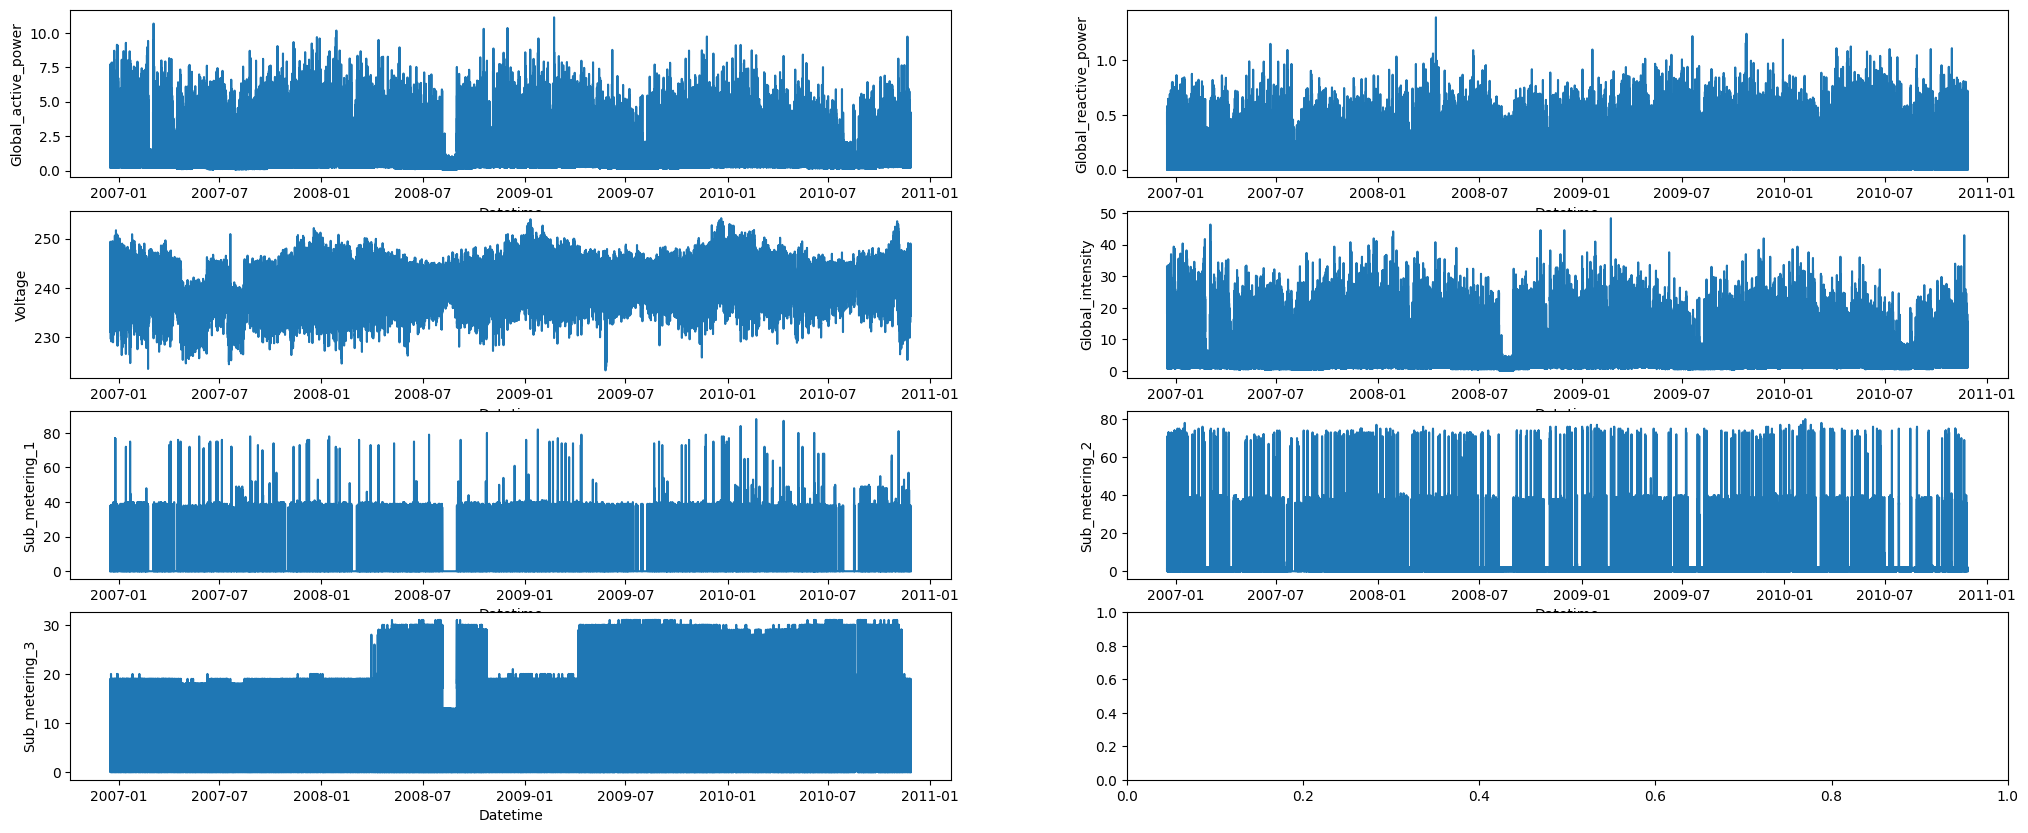

In [28]:
fig, axes = plt.subplots(4, 2, figsize = (25, 10))
axes = axes.flatten()

sns.lineplot(ax = axes[0], x = data.index, y = data['Global_active_power']);
sns.lineplot(ax = axes[1], x = data.index, y = data['Global_reactive_power']);
sns.lineplot(ax = axes[2], x = data.index, y = data['Voltage']);
sns.lineplot(ax = axes[3], x = data.index, y = data['Global_intensity']);
sns.lineplot(ax = axes[4], x = data.index, y = data['Sub_metering_1']);
sns.lineplot(ax = axes[5], x = data.index, y = data['Sub_metering_2']);
sns.lineplot(ax = axes[6], x = data.index, y = data['Sub_metering_3']);


<Axes: >

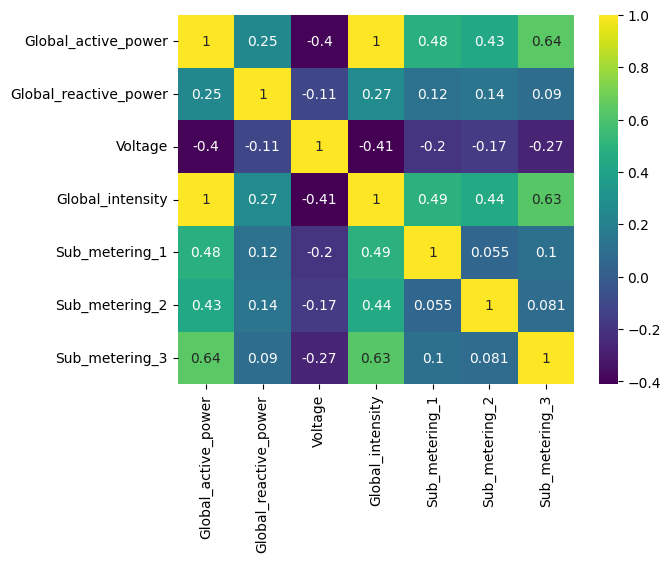

In [29]:
sns.heatmap(data=data.corr(), annot=True, cmap='viridis')

In [30]:
daily_data = data.resample('D').sum()

In [31]:
daily_data

Global_active_power  Global_reactive_power    Voltage  \
Datetime                                                            
2006-12-16             1209.176                 34.922   93552.53   
2006-12-17             3390.460                226.006  345725.32   
2006-12-18             2203.826                161.792  347373.64   
2006-12-19             1666.194                150.942  348479.01   
2006-12-20             2225.748                160.998  348923.61   
...                         ...                    ...        ...   
2010-11-22             2041.536                142.354  345883.85   
2010-11-23             1577.536                137.450  346428.76   
2010-11-24             1796.248                132.460  345644.59   
2010-11-25             1431.164                116.128  347812.21   
2010-11-26             1488.104                120.826  303487.57   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
Datetime                                                                      
2006-12-16            5180.8             0.0           546.0          4926.0  
2006-12-17           14398.6          2033.0          4187.0         13341.0  
2006-12-18            9247.2          1063.0          2621.0         14018.0  
2006-12-19            7094.0           839.0          7602.0          6197.0  
2006-12-20            9313.0             0.0          2648.0         14063.0  
...                      ...             ...             ...             ...  
2010-11-22            8660.4          4855.0          2110.0         10136.0  
2010-11-23            6731.2          1871.0           458.0          7611.0  
2010-11-24            7559.4          1096.0          2848.0         12224.0  
2010-11-25            6004.0          1076.0           426.0          5072.0  
2010-11-26            6259.8          1080.0           385.0          9989.0  

[1442 rows x 7 columns]

In [32]:
daily_data.shape

(1442, 7)

Text(0.5, 1.0, '1-MONTH AVERAGE')

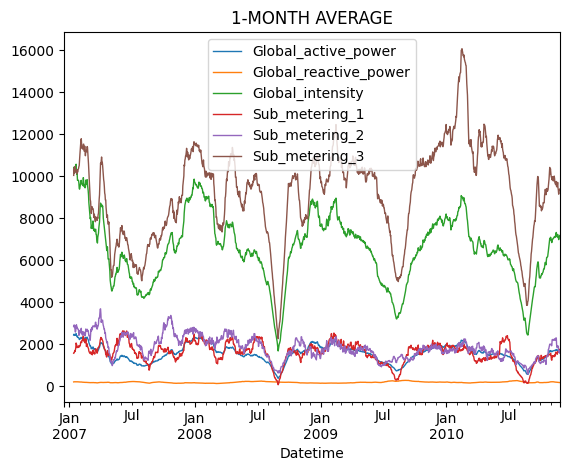

In [33]:
daily_data.groupby(['Datetime'])[['Global_active_power', 'Global_reactive_power',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3']].mean().rolling(30).mean().plot(linewidth=1)
plt.title('1-MONTH AVERAGE')

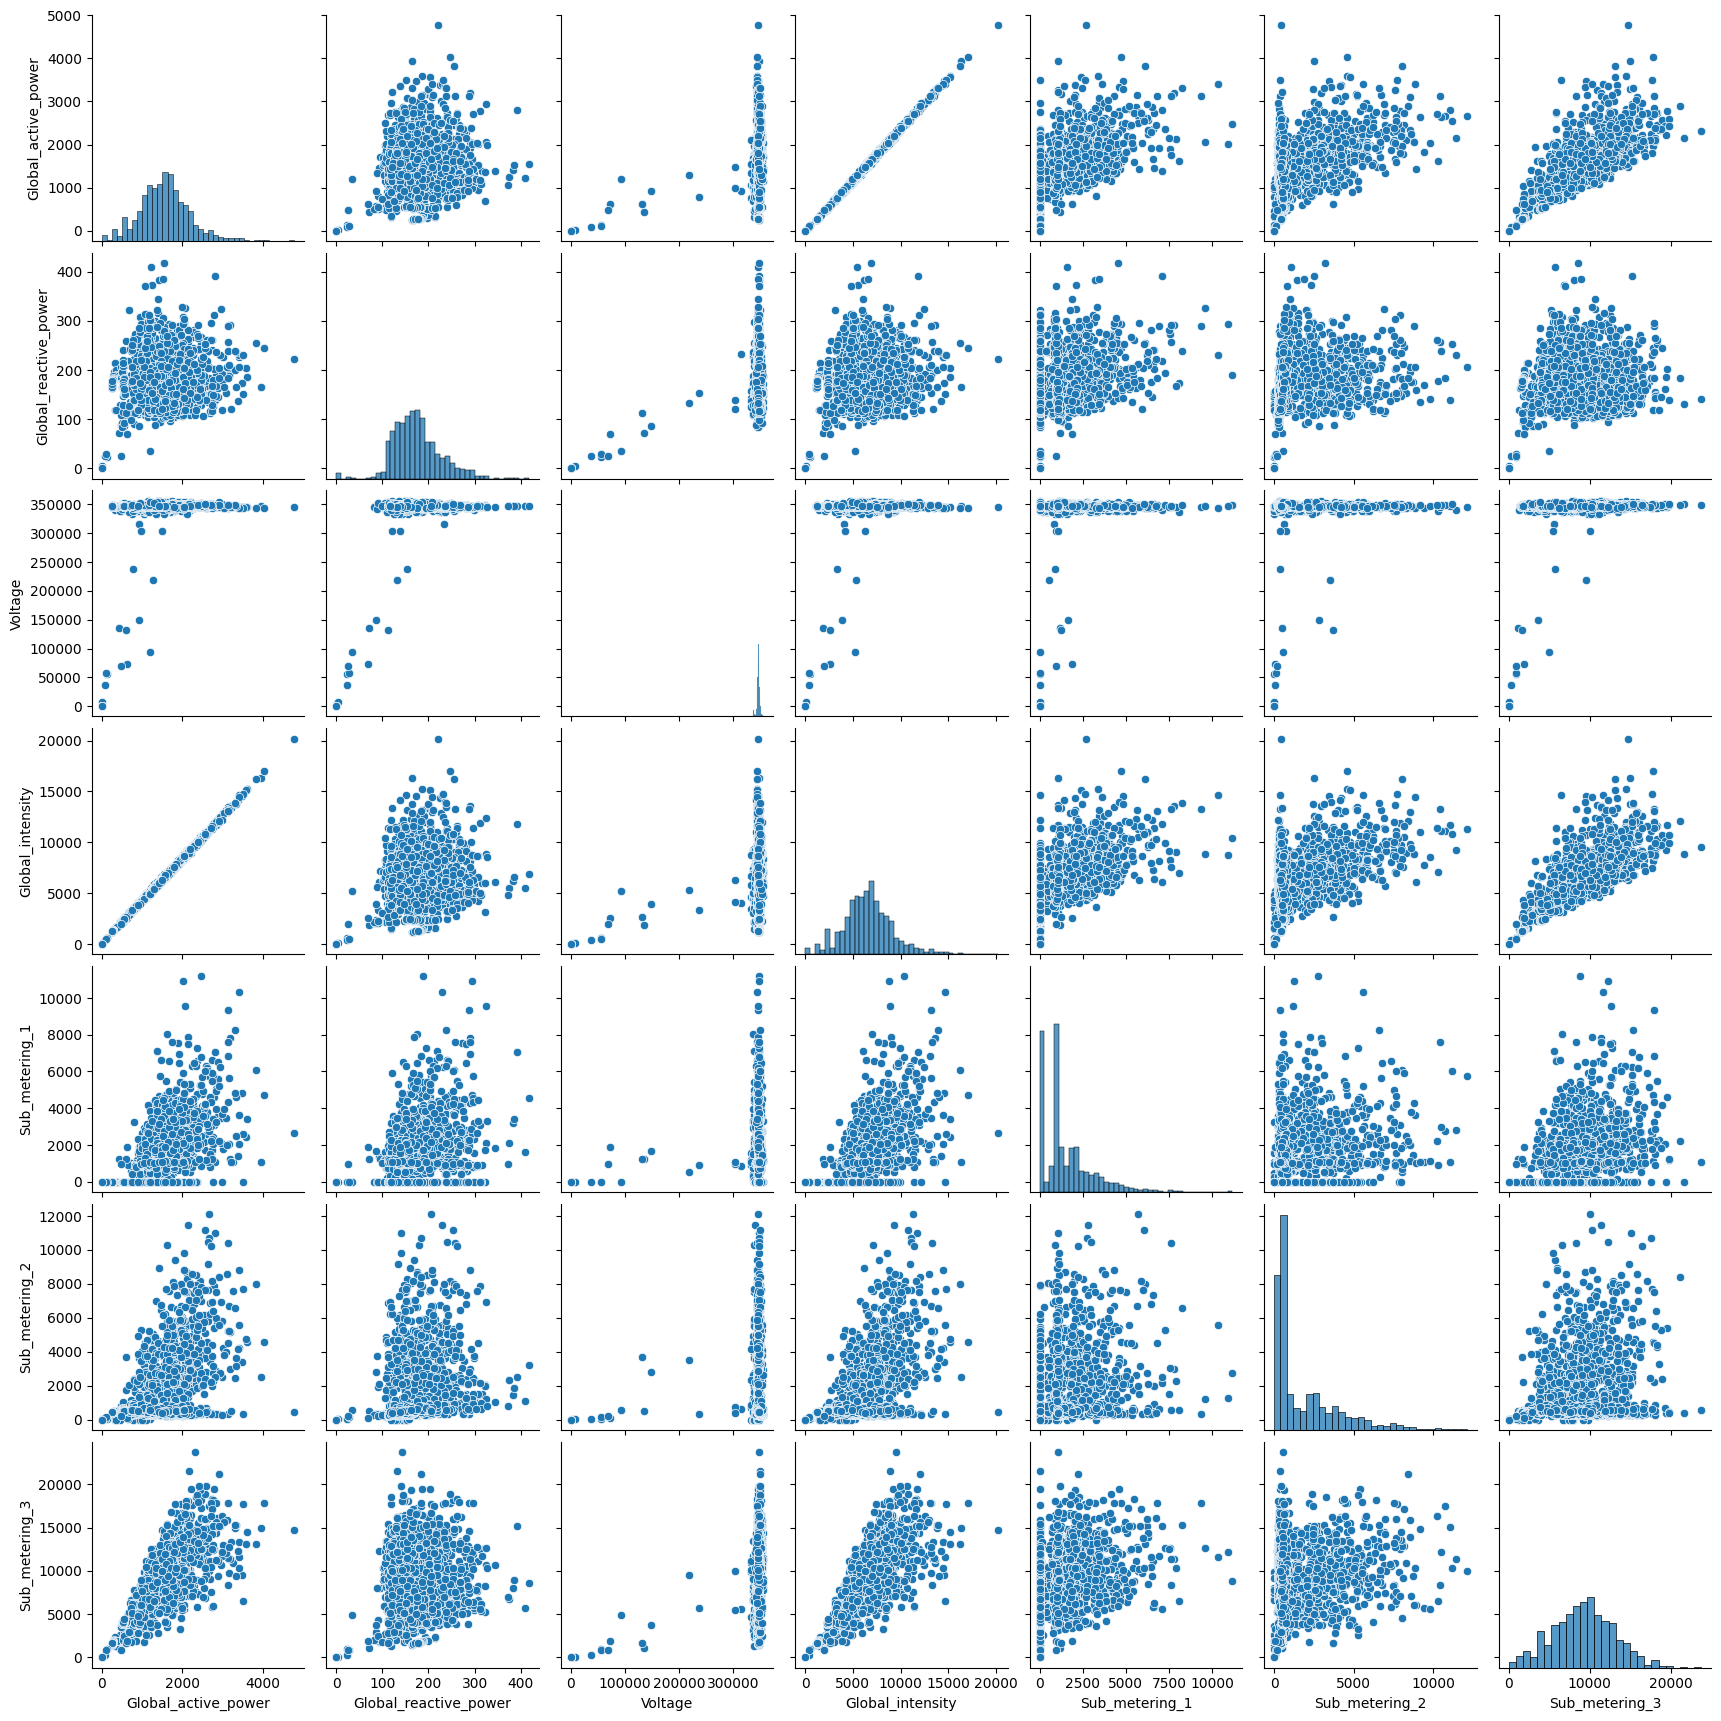

In [34]:
sns.pairplot(daily_data)

In [35]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

In [36]:
additive_decomposition = seasonal_decompose(daily_data['Global_active_power'], model='additive', period=30)

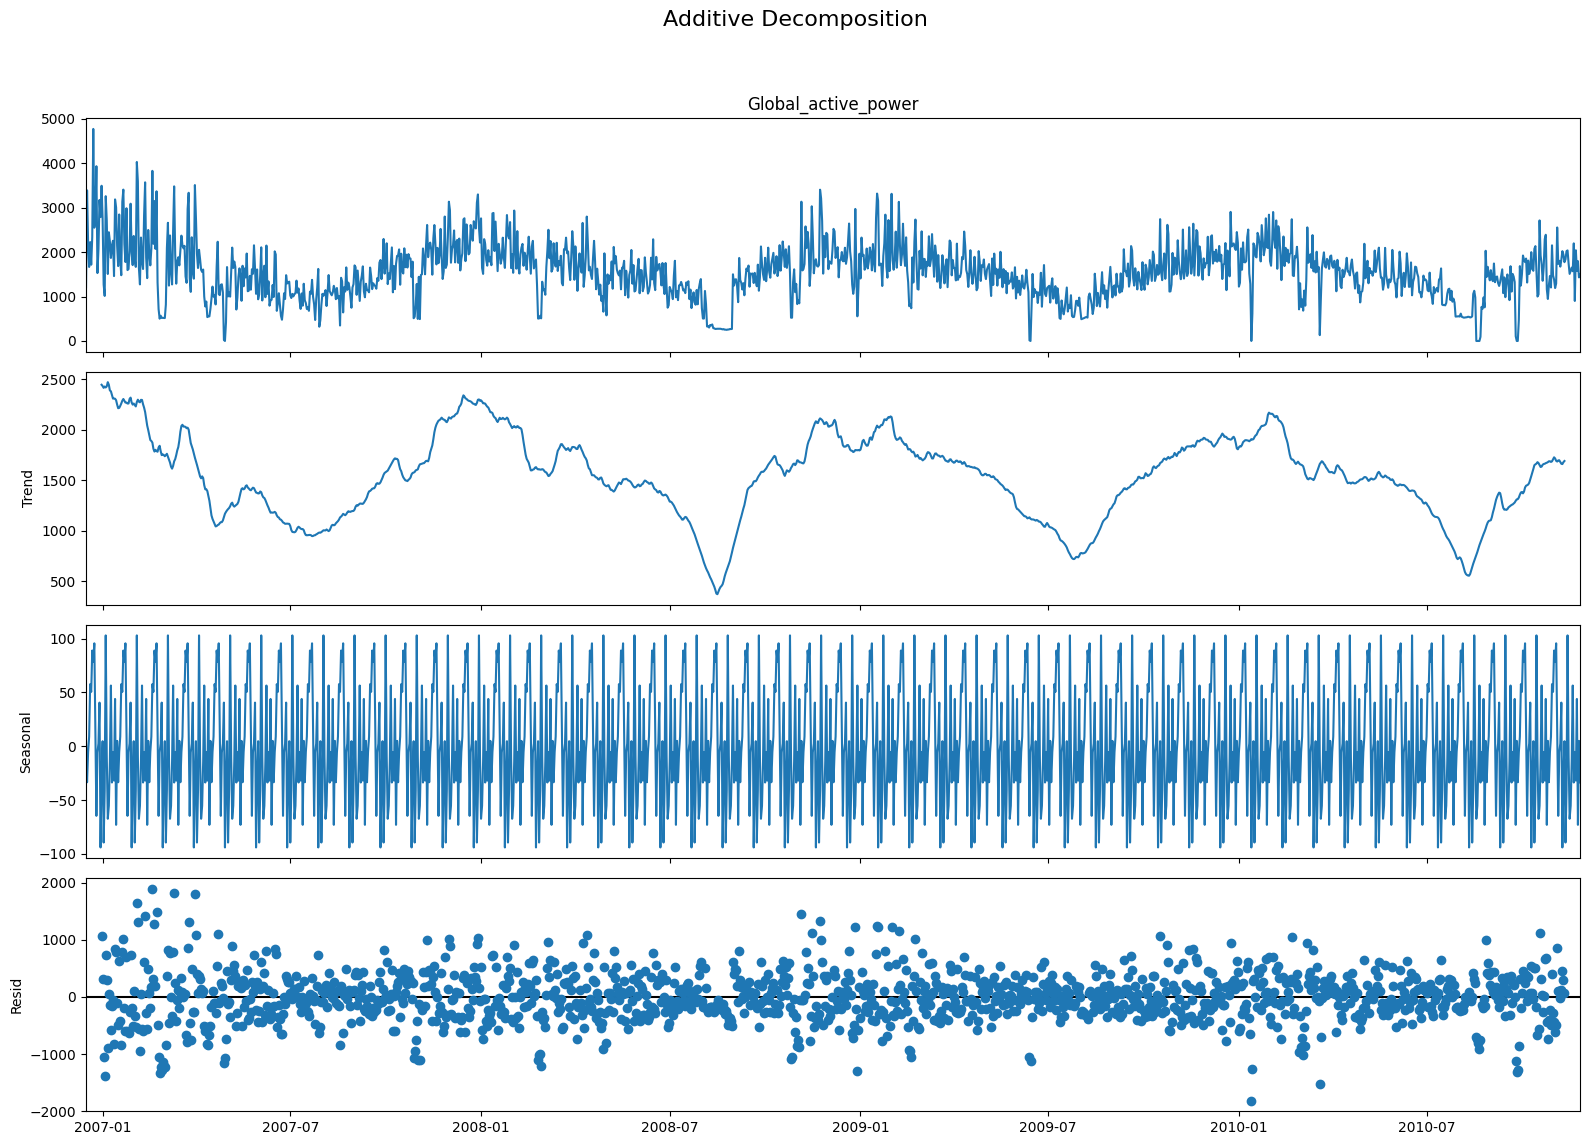

In [37]:
plt.rcParams.update({'figure.figsize': (16,12)})
additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

In [38]:
daily_data[['Global_active_power']]

Global_active_power
Datetime                       
2006-12-16             1209.176
2006-12-17             3390.460
2006-12-18             2203.826
2006-12-19             1666.194
2006-12-20             2225.748
...                         ...
2010-11-22             2041.536
2010-11-23             1577.536
2010-11-24             1796.248
2010-11-25             1431.164
2010-11-26             1488.104

[1442 rows x 1 columns]

In [39]:
closedf = daily_data.reset_index()[['Datetime', 'Global_active_power']].rename(columns={'Datetime':'ds',
                     'Global_active_power':'y'})

In [40]:
closedf.head()

ds         y
0 2006-12-16  1209.176
1 2006-12-17  3390.460
2 2006-12-18  2203.826
3 2006-12-19  1666.194
4 2006-12-20  2225.748

In [41]:
m = Prophet(interval_width=0.95, daily_seasonality=True)
prophet = m.fit(closedf)

18:33:05 - cmdstanpy - INFO - Chain [1] start processing
18:33:06 - cmdstanpy - INFO - Chain [1] done processing


In [42]:
future = m.make_future_dataframe(periods=100,freq='D')
forecast = m.predict(future)
forecast.head()

ds        trend   yhat_lower   yhat_upper  trend_lower  trend_upper  \
0 2006-12-16  1292.336979  1467.095378  3164.175288  1292.336979  1292.336979   
1 2006-12-17  1292.225389  1488.950051  3212.156064  1292.225389  1292.225389   
2 2006-12-18  1292.113800  1120.560320  2879.080790  1292.113800  1292.113800   
3 2006-12-19  1292.002210  1330.134594  3027.947068  1292.002210  1292.002210   
4 2006-12-20  1291.890621  1311.928977  3075.424974  1291.890621  1291.890621   

   additive_terms  additive_terms_lower  additive_terms_upper       daily  \
0     1029.730005           1029.730005           1029.730005  333.734146   
1     1015.598627           1015.598627           1015.598627  333.734146   
2      741.819545            741.819545            741.819545  333.734146   
3      864.285139            864.285139            864.285139  333.734146   
4      893.769571            893.769571            893.769571  333.734146   

   ...      weekly  weekly_lower  weekly_upper      yearly  yearly_lower  \
0  ...  198.719191    198.719191    198.719191  497.276668    497.276668   
1  ...  166.431406    166.431406    166.431406  515.433075    515.433075   
2  ... -125.538410   -125.538410   -125.538410  533.623809    533.623809   
3  ...  -20.785327    -20.785327    -20.785327  551.336319    551.336319   
4  ...   -8.029937     -8.029937     -8.029937  568.065362    568.065362   

   yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
0    497.276668                   0.0                         0.0   
1    515.433075                   0.0                         0.0   
2    533.623809                   0.0                         0.0   
3    551.336319                   0.0                         0.0   
4    568.065362                   0.0                         0.0   

   multiplicative_terms_upper         yhat  
0                         0.0  2322.066984  
1                         0.0  2307.824017  
2                         0.0  2033.933345  
3                         0.0  2156.287349  
4                         0.0  2185.660191  

[5 rows x 22 columns]

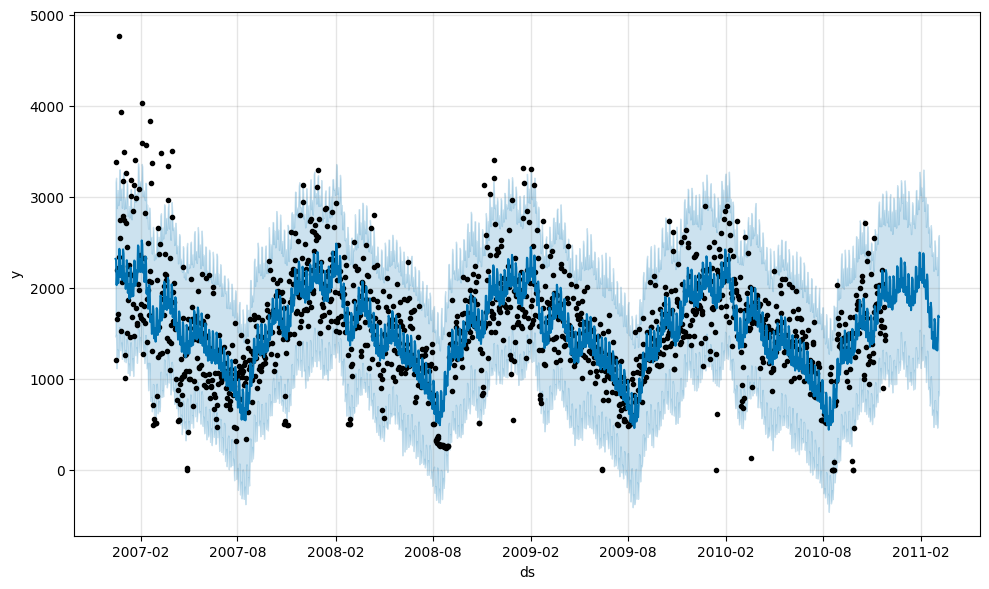

In [43]:
m.plot(forecast);

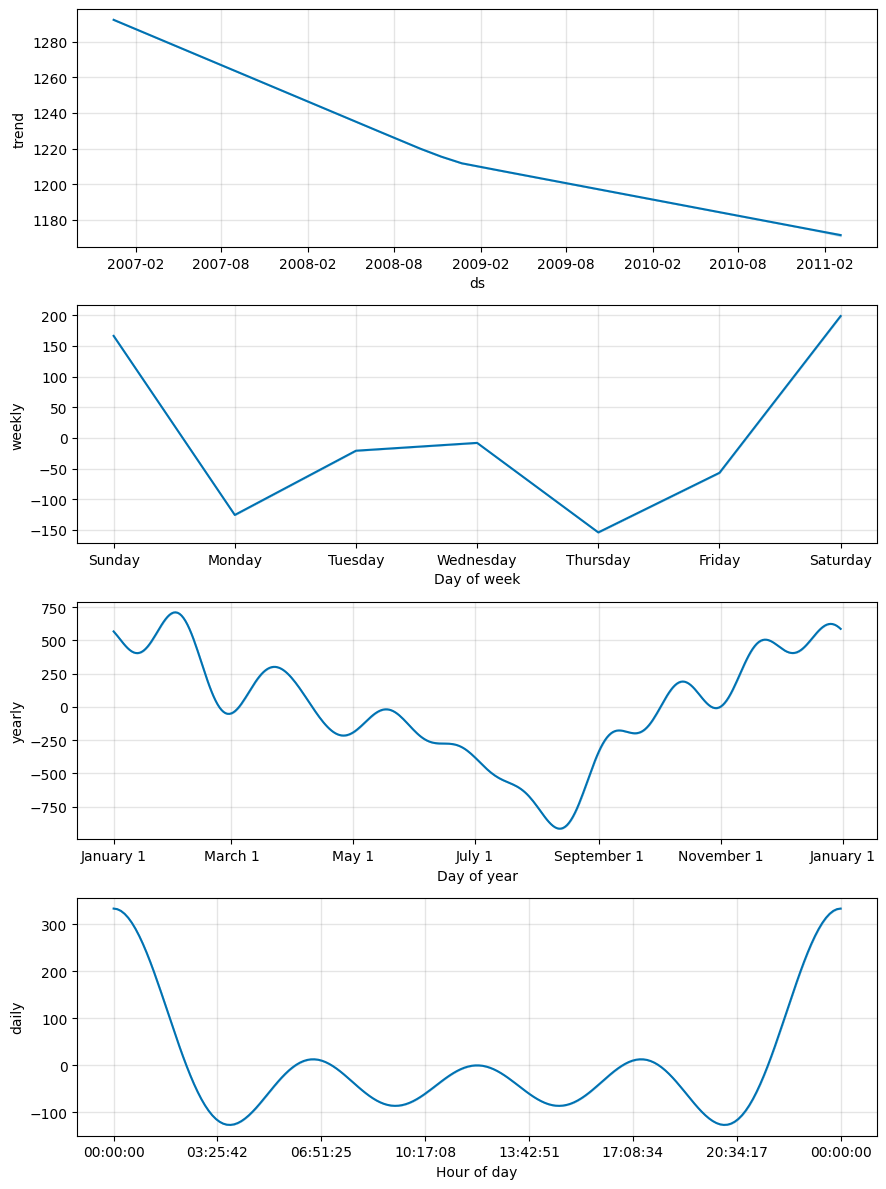

In [44]:
m.plot_components(forecast);

In [45]:
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [46]:
target_series = daily_data['Global_active_power']

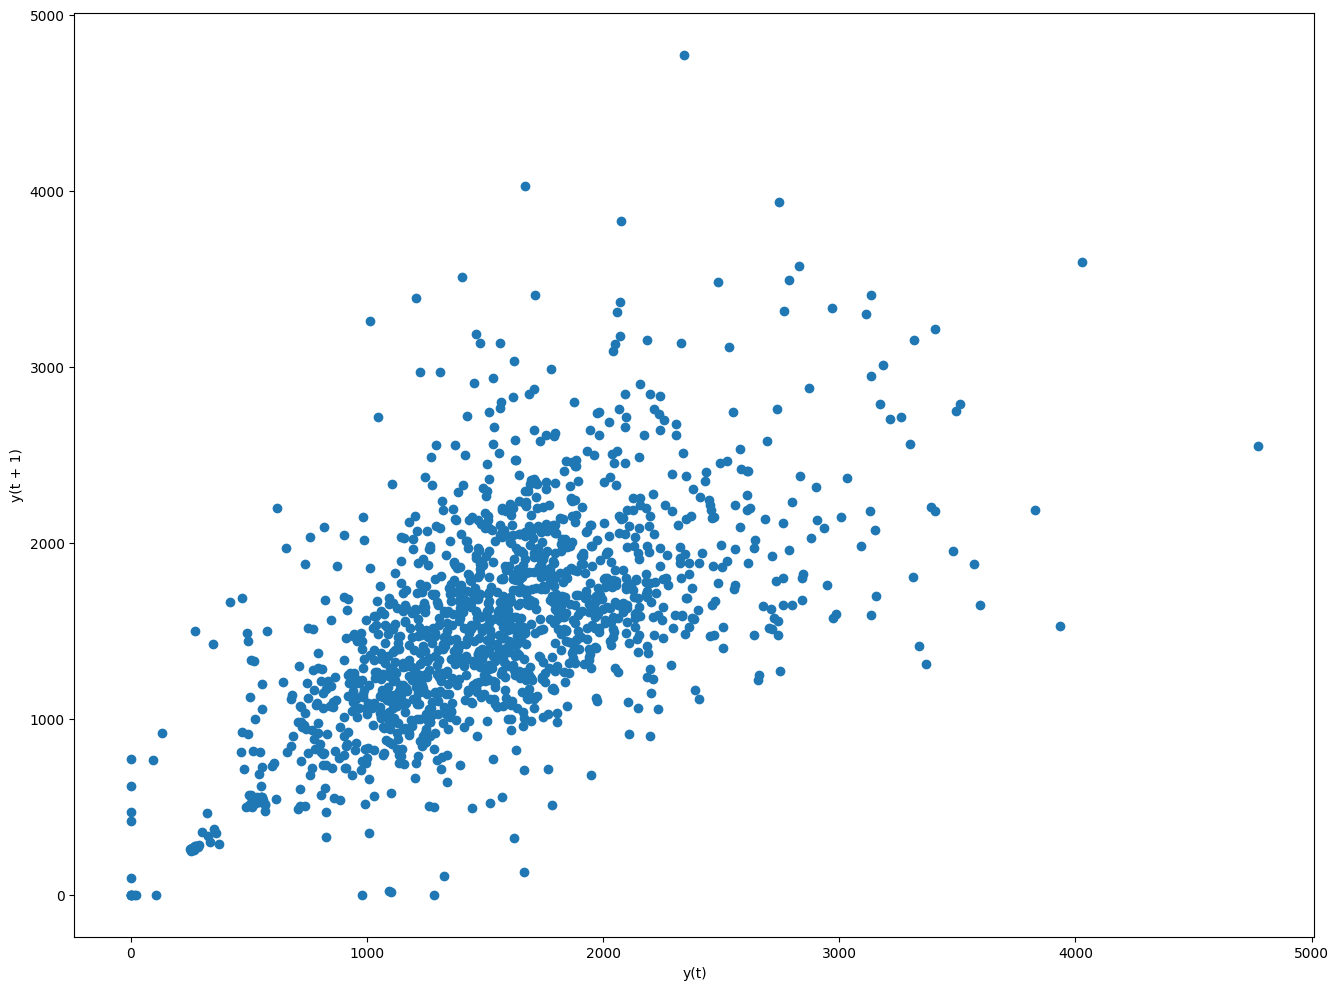

In [47]:
lag_plot(target_series)
plt.show()

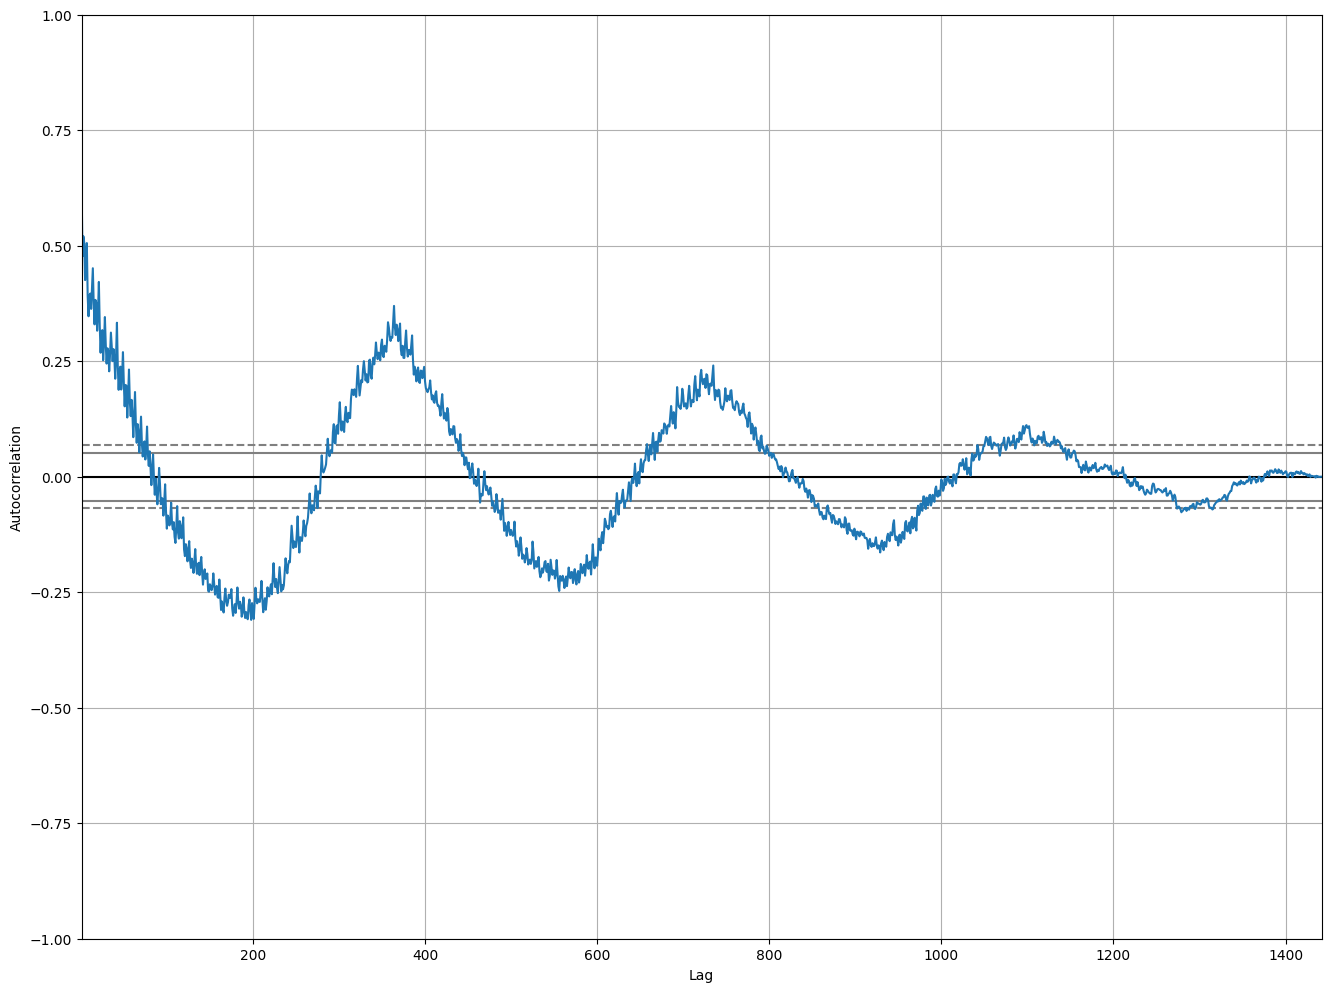

In [48]:
autocorrelation_plot(target_series)
plt.show()

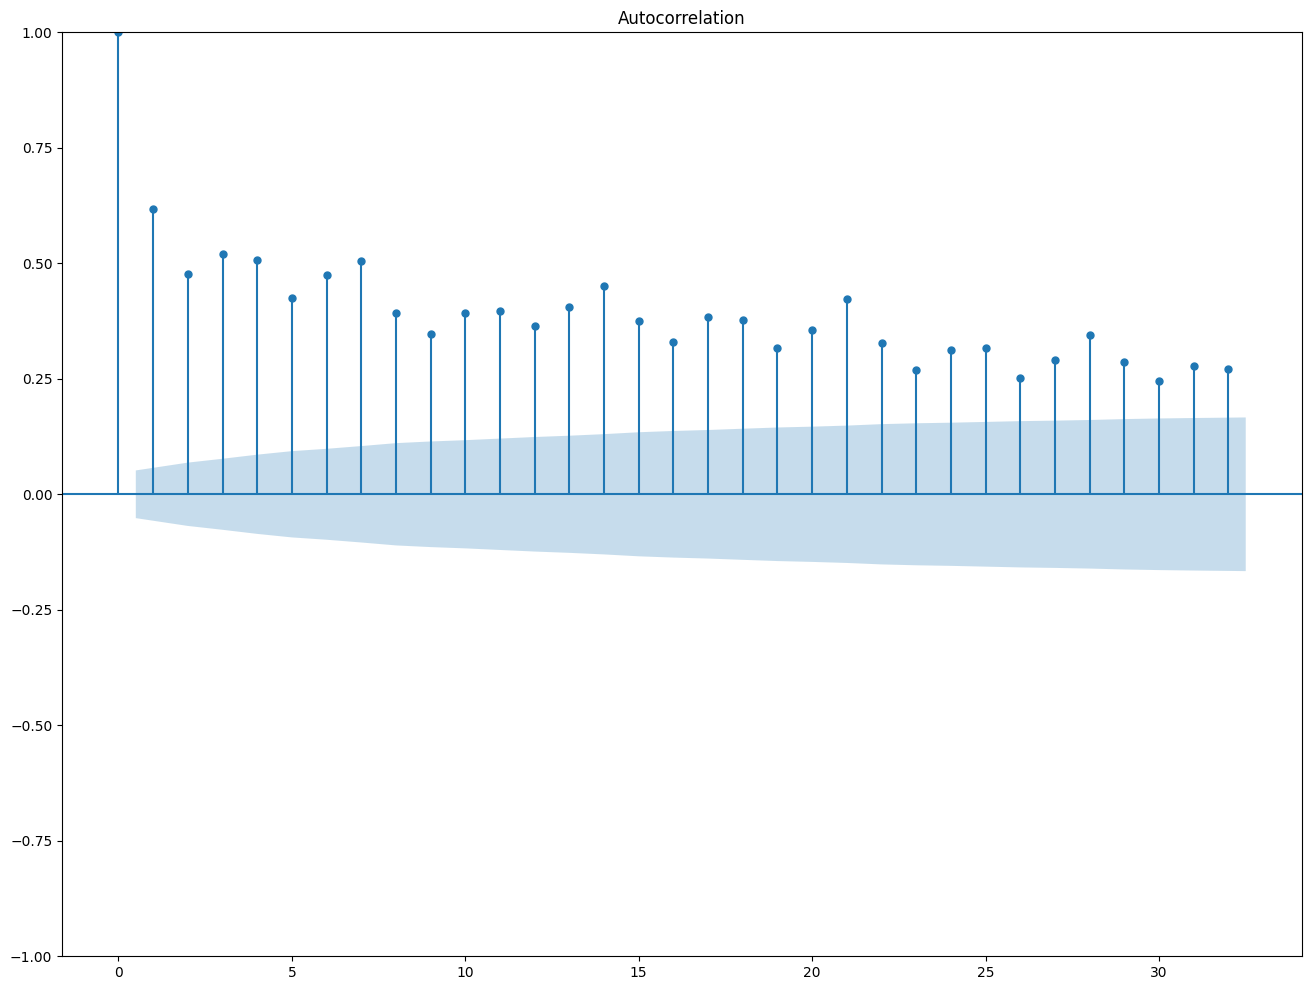

In [49]:
plot_acf(target_series)
plt.show()

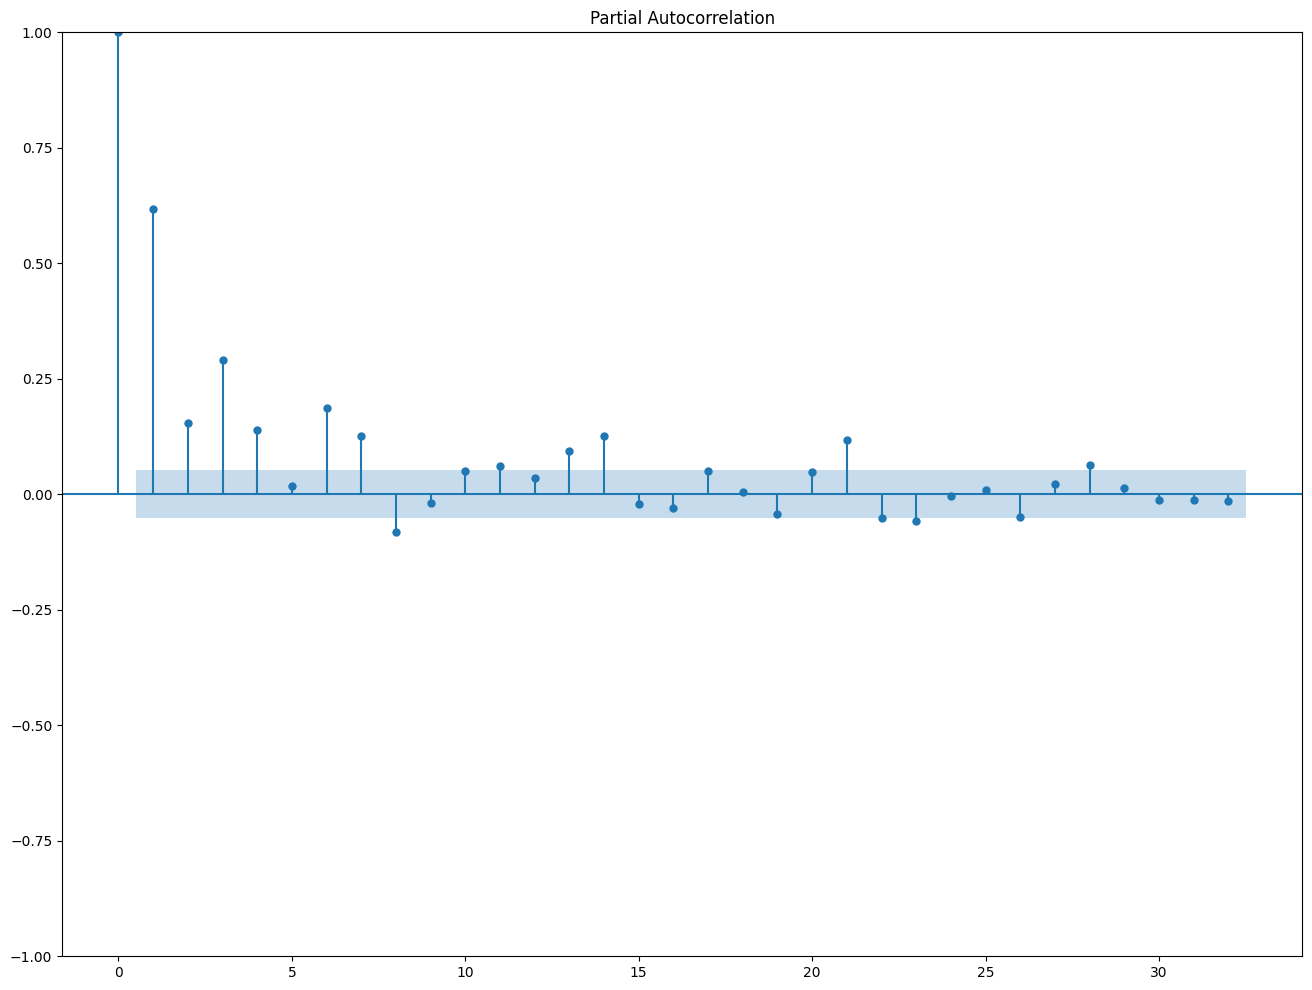

In [50]:
plot_pacf(target_series)
plt.show()

In [51]:
daily_data['Global_active_power'][daily_data['Global_active_power']>4000]

Datetime
2006-12-23    4773.386
2007-02-03    4029.722
Name: Global_active_power, dtype: float64

In [52]:
daily_data['Global_reactive_power'][daily_data['Global_reactive_power']>400]

Datetime
2009-08-16    409.052
2009-08-22    417.834
Name: Global_reactive_power, dtype: float64

<Axes: xlabel='Datetime', ylabel='Global_active_power'>

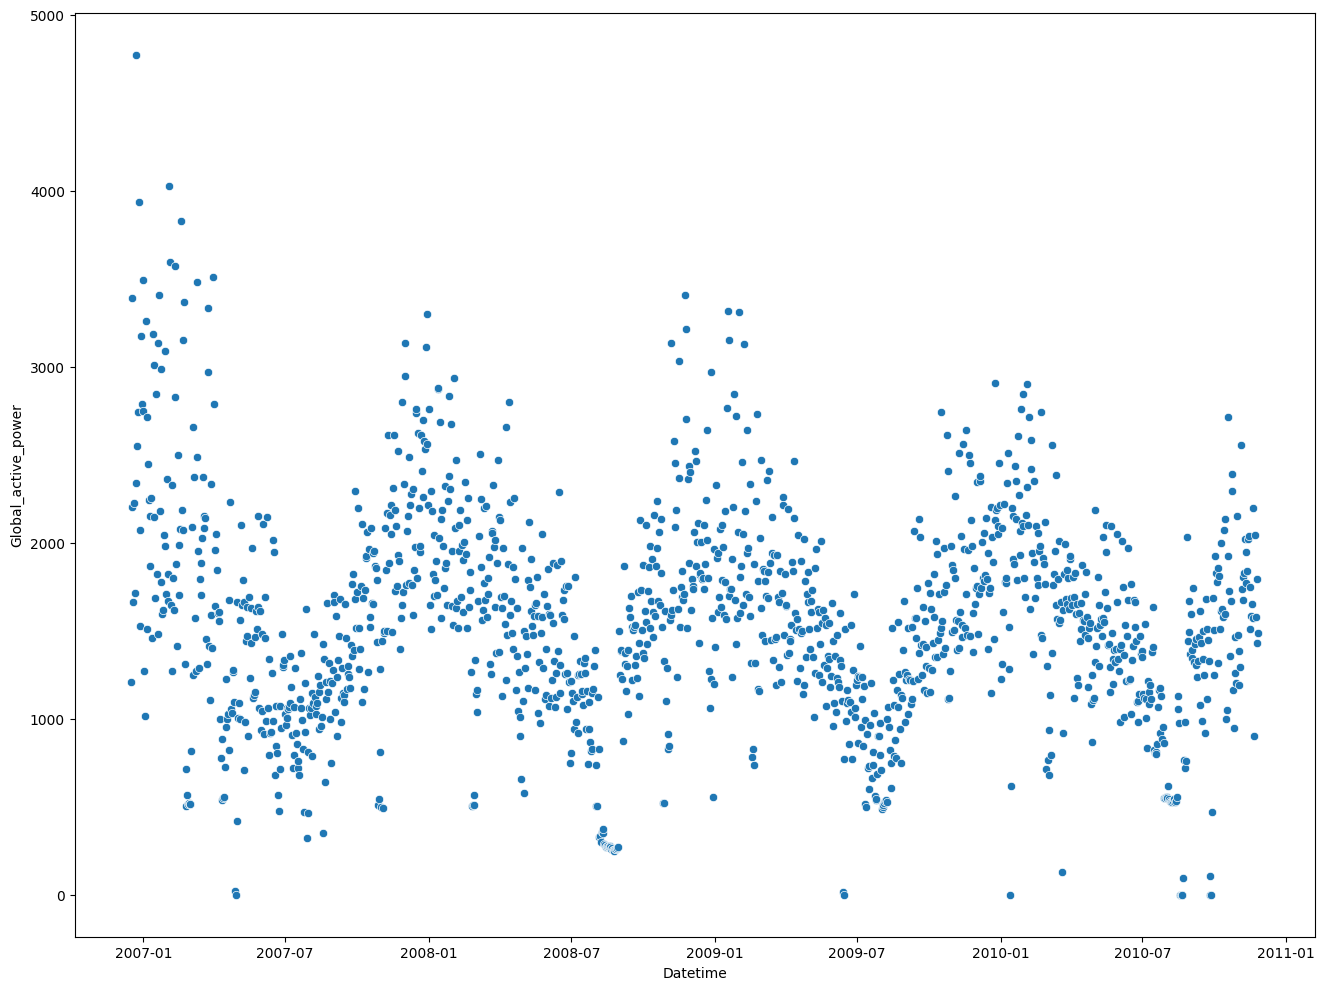

In [53]:
sns.scatterplot(daily_data['Global_active_power'])

In [54]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') 
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
        


In [55]:
# use ADF function       
adf_test(daily_data['Global_active_power'])

Augmented Dickey-Fuller Test: 
ADF test statistic        -3.849777
p-value                    0.002437
# lags used               22.000000
# observations          1419.000000
critical value (1%)       -3.434967
critical value (5%)       -2.863579
critical value (10%)      -2.567856
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


# 3. Time Series Forecasting Models/Model Evaluation and Tuning:

## Global Active Power

In [56]:
test_size = daily_data[daily_data.index.year>2009].shape[0]
test_size

330

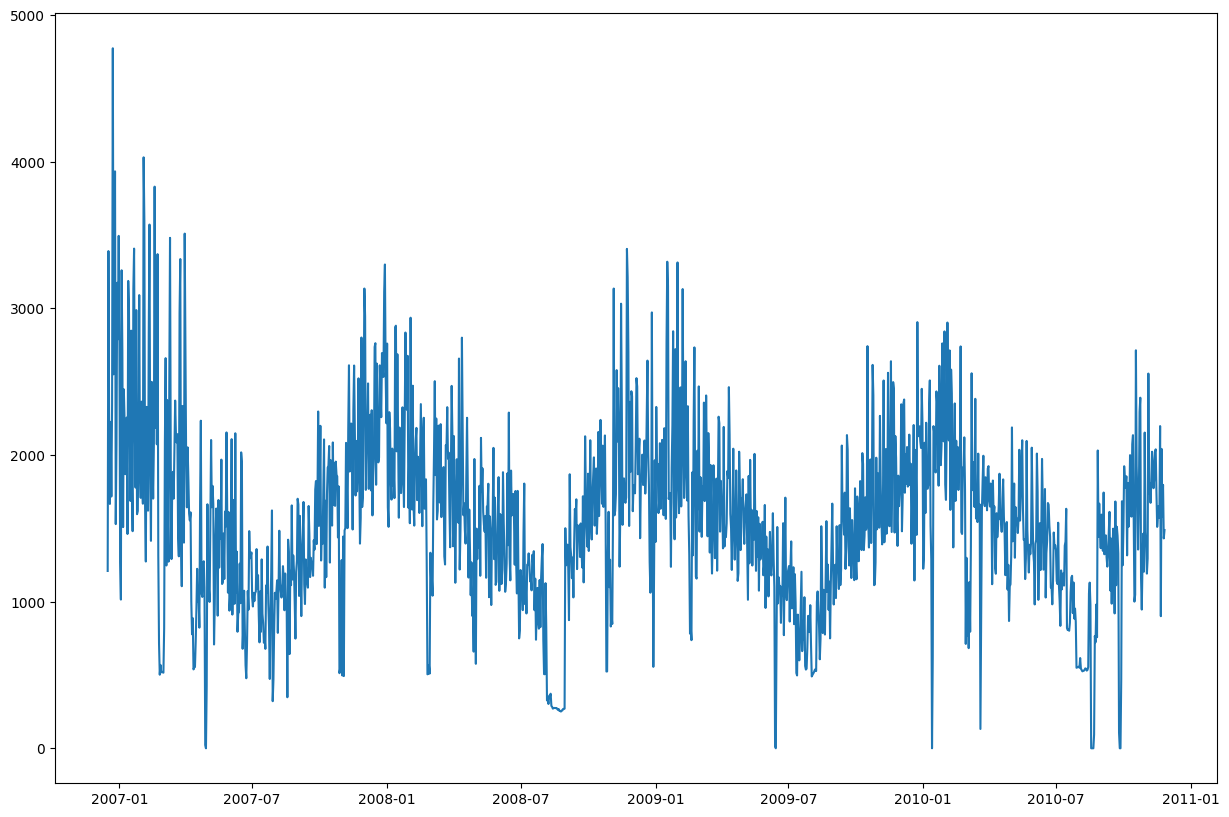

In [57]:
plt.figure(figsize=(15,10))

plt.plot(daily_data['Global_active_power'])

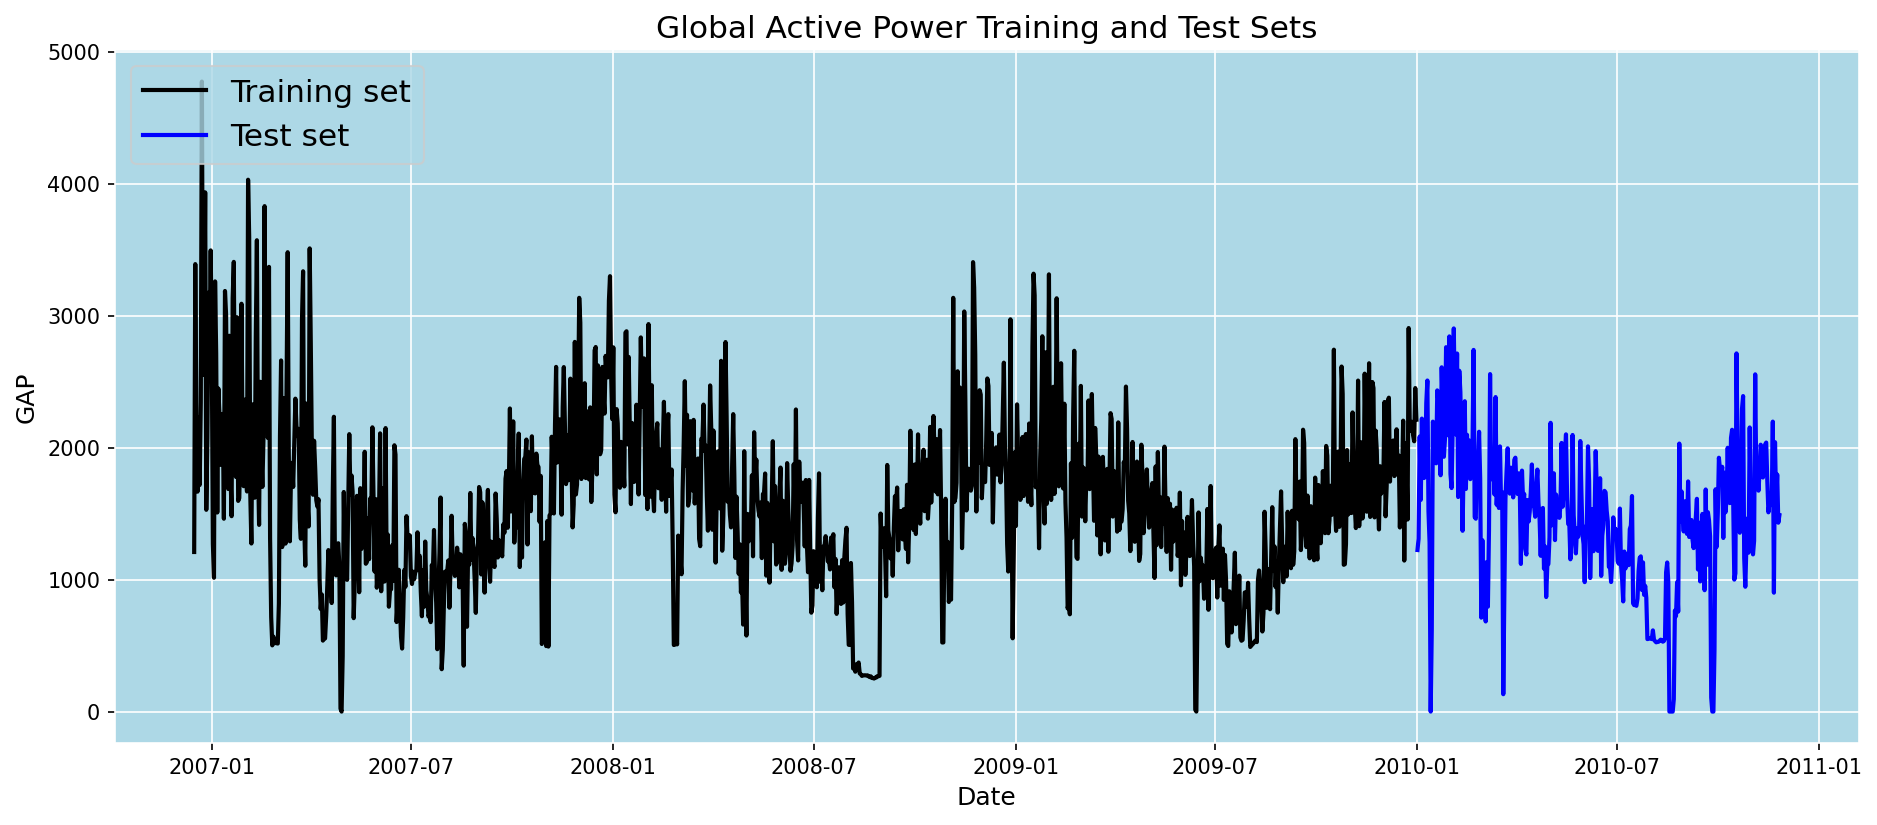

In [58]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'lightblue'
plt.rc('axes',edgecolor='white')
plt.plot(daily_data.index[:-test_size], daily_data['Global_active_power'][:-test_size], color='black', lw=2)
plt.plot(daily_data.index[-test_size:], daily_data['Global_active_power'][-test_size:], color='blue', lw=2)
plt.title('Global Active Power Training and Test Sets', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('GAP', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [59]:
scaler = MinMaxScaler()

In [60]:
scaler.fit(daily_data['Global_active_power'].values.reshape(-1,1))

MinMaxScaler()

In [61]:
def validate_result(model, model_name, n_periods=None):
    if n_periods is None:
        predicted = model.predict(X_test)
    else:
        predicted = model.predict(n_periods= n_periods, X=X_test)

    RMSE_score = np.sqrt(mean_squared_error(y_test, predicted))
    print(f'{model_name} RMSE: ', RMSE_score)

    y_tes  = np.reshape(y_test, (-1,1))
    y_pred = np.reshape(predicted, (-1,1))
    y_test_true = scaler.inverse_transform(y_tes)
    y_test_pred = scaler.inverse_transform(y_pred)
    
    plt.figure(figsize=(15, 6), dpi=150)
    plt.rcParams['axes.facecolor'] = 'lightblue'
    plt.rc('axes',edgecolor='white')
    plt.plot(daily_data.index[-test_size:], y_test_true, color='blue', lw=2)
    plt.plot(daily_data.index[-test_size:], y_test_pred, color='red', lw=2)
    plt.title(f'{model_name} Model Performance on Global Active Power Prediction', fontsize=15)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Global Active Power', fontsize=12)
    plt.legend(['Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
    plt.grid(color='white')
    plt.show()

    return RMSE_score, predicted


In [62]:
def data_arima(x):
    window_size = x
    train_data = daily_data['Global_active_power'][:-test_size]
    train_data = scaler.transform(train_data.values.reshape(-1,1))
    X_train = []
    y_train = []

    for i in range(window_size, len(train_data)):
        X_train.append(train_data[i-x:i, 0])
        y_train.append(train_data[i, 0])

    test_data = daily_data['Global_active_power'][-test_size-x:]
    test_data = scaler.transform(test_data.values.reshape(-1,1))

    X_test = []
    y_test = []

    for i in range(window_size, len(test_data)):
        X_test.append(test_data[i-x:i, 0])
        y_test.append(test_data[i, 0])

    X_train = np.array(X_train)
    X_test  = np.array(X_test)
    y_train = np.array(y_train)
    y_test  = np.array(y_test)

    return X_train, X_test, y_train, y_test

## ARIMA

In [63]:
X_train, X_test, y_train, y_test = data_arima(30)

In [64]:
from pmdarima import auto_arima

In [65]:
arima30 = auto_arima(y= y_train, X= X_train, m=7)

In [66]:
arima30.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:                         y   No. Observations:                 1082
Model:             SARIMAX(0, 0, [1], 7)   Log Likelihood                1143.575
Date:                   Sat, 06 Jul 2024   AIC                          -2221.149
Time:                           18:38:26   BIC                          -2056.592
Sample:                                0   HQIC                         -2158.846
                                  - 1082                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0087      0.004      2.308      0.021       0.001       0.016
x1             0.0145      0.030      0.476      0.634      -0.045       0.074
x2             0.0227      0.030      0.747      0.455      -0.037       0.082
x3            -0.0054      0.031     -0.174      0.862      -0.067       0.056
x4             0.0095      0.033      0.286      0.775      -0.056       0.075
x5            -0.0626      0.033     -1.904      0.057      -0.127       0.002
x6             0.0111      0.033      0.338      0.736      -0.053       0.075
x7            -0.0488      0.031     -1.597      0.110      -0.109       0.011
x8            -0.0277      0.045     -0.620      0.535      -0.115       0.060
x9            -0.0197      0.041     -0.479      0.632      -0.100       0.061
x10            0.0368      0.039      0.938      0.348      -0.040       0.114
x11           -0.0439      0.045     -0.982      0.326      -0.132       0.044
x12           -0.0043      0.046     -0.093      0.926      -0.095       0.086
x13           -0.0647      0.044     -1.478      0.139      -0.150       0.021
x14            0.0921      0.046      2.023      0.043       0.003       0.181
x15            0.0198      0.048      0.415      0.678      -0.074       0.113
x16            0.0428      0.042      1.014      0.310      -0.040       0.126
x17            0.0028      0.045      0.062      0.950      -0.085       0.091
x18            0.0262      0.043      0.613      0.540      -0.058       0.110
x19            0.0640      0.048      1.343      0.179      -0.029       0.157
x20           -0.0649      0.041     -1.599      0.110      -0.144       0.015
x21           -0.1031      0.041     -2.487      0.013      -0.184      -0.022
x22           -0.1049      0.041     -2.561      0.010      -0.185      -0.025
x23           -0.4118      0.045     -9.223      0.000      -0.499      -0.324
x24            0.8447      0.054     15.738      0.000       0.740       0.950
x25            0.0347      0.033      1.040      0.298      -0.031       0.100
x26           -0.0147      0.034     -0.428      0.669      -0.082       0.053
x27            0.1494      0.029      5.239      0.000       0.093       0.205
x28            0.0822      0.030      2.716      0.007       0.023       0.141
x29            0.0815      0.028      2.911      0.004       0.027       0.136
x30            0.4147      0.025     16.824      0.000       0.366       0.463
ma.S.L7       -0.7387      0.047    -15.861      0.000      -0.830      -0.647
sigma2         0.0070      0.000     28.376      0.000       0.007       0.007
===================================================================================
Ljung-Box (L1) (Q):                   0.39   Jarque-Bera (JB):               216.73
Prob(Q):                              0.53   Prob(JB):                         0.00
Heteroskedasticity (H):               0.65   Skew:                             0.22
Prob(H) (two-sided):              

ARIMA30 RMSE:  0.1090250383465432


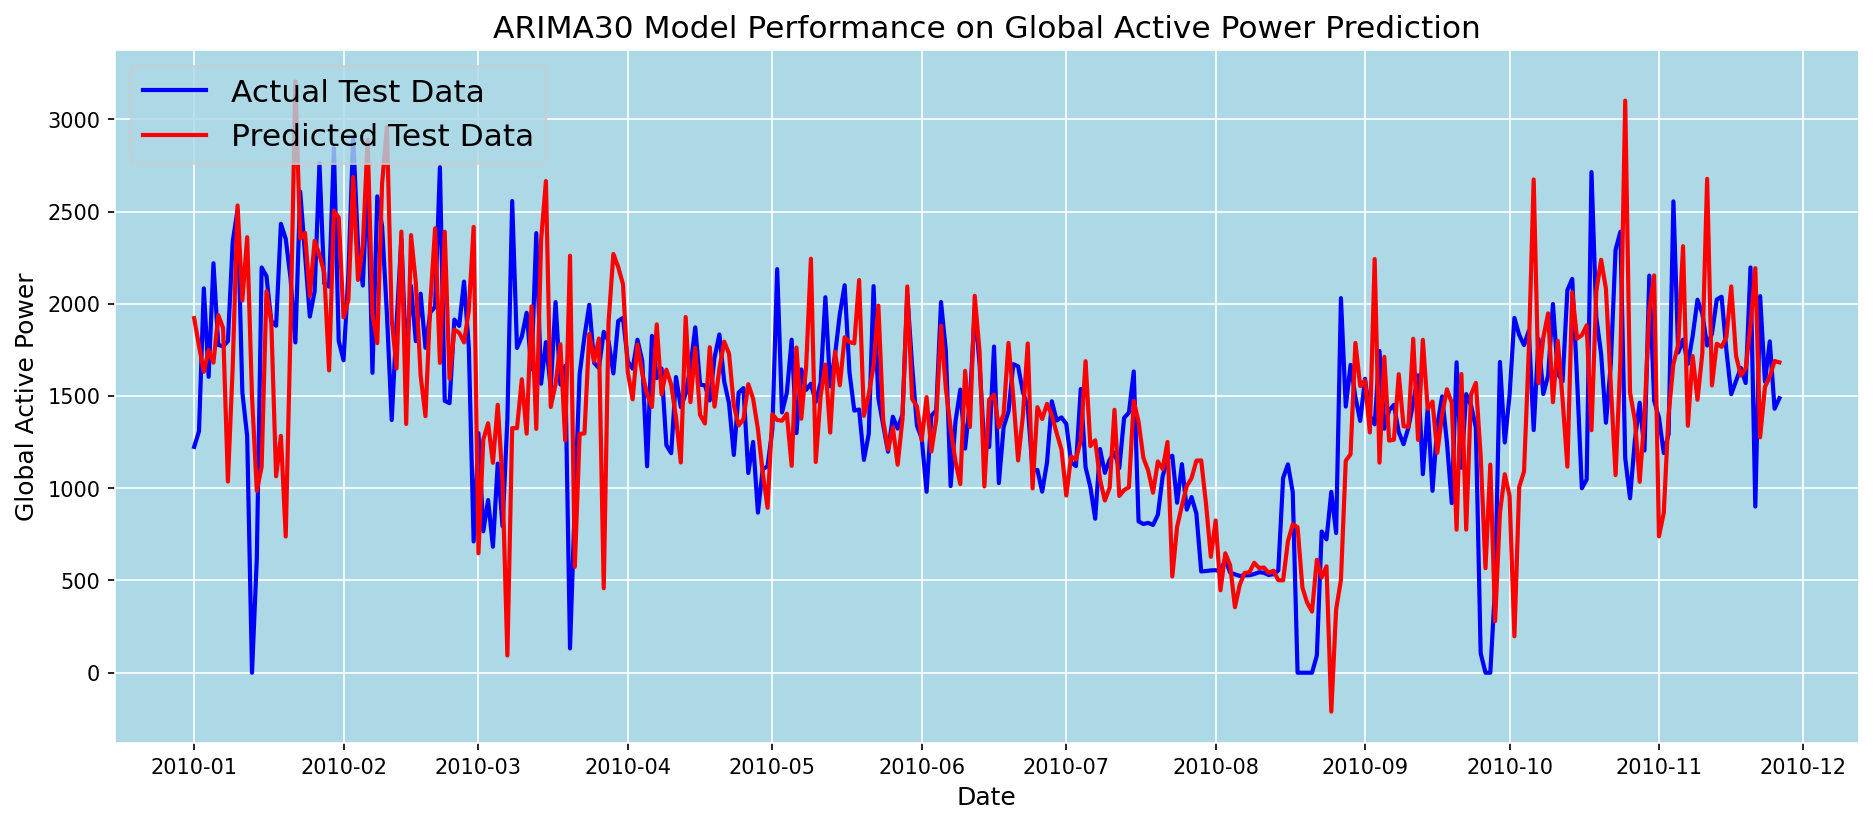

In [67]:
ARIMA30_RMSE = validate_result(arima30, 'ARIMA30', n_periods=330)

In [68]:
X_train, X_test, y_train, y_test = data_arima(60)

In [69]:
arima60 = auto_arima(y= y_train, X= X_train, m=7)

In [70]:
arima60.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  SARIMAX Results                                   
====================================================================================
Dep. Variable:                            y   No. Observations:                 1052
Model:             SARIMAX(0, 0, [1, 2], 7)   Log Likelihood                1144.077
Date:                      Sat, 06 Jul 2024   AIC                          -2160.154
Time:                              18:48:32   BIC                          -1842.813
Sample:                                   0   HQIC                         -2039.840
                                     - 1052                                         
Covariance Type:                        opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0285      0.011      2.645      0.008       0.007       0.050
x1            -0.0717      0.031     -2.339      0.019      -0.132      -0.012
x2             0.0195      0.032      0.609      0.543      -0.043       0.082
x3             0.0013      0.034      0.038      0.970      -0.065       0.068
x4            -0.0490      0.034     -1.421      0.155      -0.117       0.019
x5             0.1026      0.034      2.983      0.003       0.035       0.170
x6            -0.0189      0.034     -0.551      0.582      -0.086       0.048
x7            -0.0493      0.033     -1.506      0.132      -0.113       0.015
x8             0.0401      0.037      1.094      0.274      -0.032       0.112
x9            -0.0145      0.037     -0.393      0.694      -0.087       0.058
x10            0.0053      0.036      0.147      0.884      -0.065       0.076
x11            0.0071      0.040      0.177      0.859      -0.072       0.086
x12           -0.0122      0.040     -0.302      0.762      -0.091       0.067
x13           -0.0169      0.039     -0.431      0.667      -0.094       0.060
x14            0.0118      0.041      0.288      0.773      -0.068       0.092
x15           -0.0078      0.041     -0.189      0.850      -0.088       0.073
x16            0.0155      0.044      0.354      0.724      -0.070       0.101
x17           -0.0389      0.043     -0.913      0.361      -0.123       0.045
x18           -0.0818      0.042     -1.968      0.049      -0.163      -0.000
x19            0.1378      0.039      3.543      0.000       0.062       0.214
x20            0.0376      0.041      0.916      0.360      -0.043       0.118
x21           -0.0389      0.042     -0.934      0.350      -0.121       0.043
x22            0.0053      0.041      0.128      0.898      -0.075       0.086
x23            0.0313      0.043      0.729      0.466      -0.053       0.116
x24            0.0225      0.039      0.574      0.566      -0.054       0.099
x25            0.0325      0.037      0.884      0.377      -0.040       0.105
x26           -0.0024      0.038     -0.063      0.950      -0.077       0.073
x27           -0.0346      0.038     -0.903      0.366      -0.110       0.041
x28           -0.0181      0.038     -0.481      0.630      -0.092       0.056
x29           -0.0010      0.039     -0.025      0.980      -0.077       0.075
x30           -0.0165      0.040     -0.410      0.682      -0.095       0.062
x31            0.0053      0.039      0.136      0.892      -0.071       0.082
x32            0.0111      0.038      0.293      0.769      -0.063       0.086
x33            0.0175      0.039      0.448      0.654      -0.059       0.094
x34            0.0215      0.040      0.532      0.595      -0.058       0.101
x35            0.0053      0.041      0.129      0.897      -0.075       0.086
x36        -8.853e-05      0.043     -0.002      0.998      -0.084       0.084
x37           -0.0350      

ARIMA60 RMSE:  0.09314164415764621


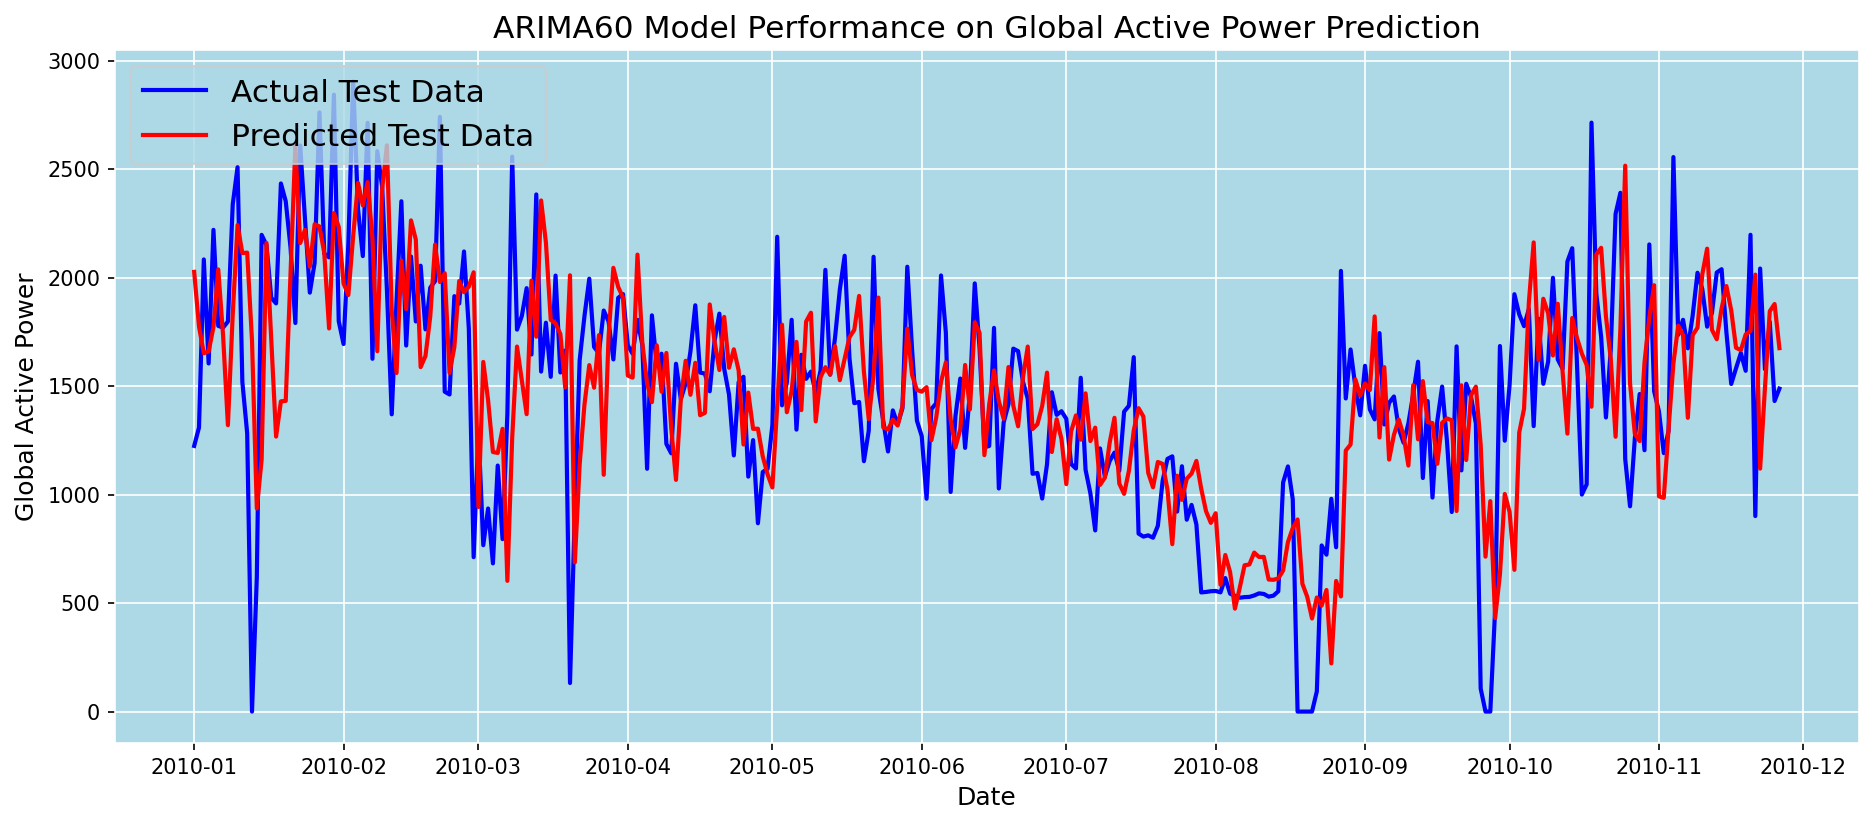

In [71]:
ARIMA60_RMSE = validate_result(arima60, 'ARIMA60', n_periods=330)

## LSTM

In [72]:
def data_lstm(x):
    window_size = x
    train_data = daily_data['Global_active_power'][:-test_size]
    train_data = scaler.transform(train_data.values.reshape(-1,1))
    X_train = []
    y_train = []

    for i in range(window_size, len(train_data)):
        X_train.append(train_data[i-x:i, 0])
        y_train.append(train_data[i, 0])

    test_data = daily_data['Global_active_power'][-test_size-x:]
    test_data = scaler.transform(test_data.values.reshape(-1,1))

    X_test = []
    y_test = []

    for i in range(window_size, len(test_data)):
        X_test.append(test_data[i-x:i, 0])
        y_test.append(test_data[i, 0])

    X_train = np.array(X_train)
    X_test  = np.array(X_test)
    y_train = np.array(y_train)
    y_test  = np.array(y_test)

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    y_train = np.reshape(y_train, (-1,1))
    y_test  = np.reshape(y_test, (-1,1))

    return X_train, X_test, y_train, y_test

In [73]:
X_train, X_test, y_train, y_test = data_lstm(30)

In [74]:
print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape:  ', X_test.shape)
print('y_test Shape:  ', y_test.shape)

X_train Shape:  (1082, 30, 1)
y_train Shape:  (1082, 1)
X_test Shape:   (330, 30, 1)
y_test Shape:   (330, 1)


### Functional

In [75]:
def define_model(window_size):
    input1 = Input(shape=(window_size,1))
    x = LSTM(units = 64, return_sequences=True)(input1)  
    x = Dropout(0.2)(x)
    x = LSTM(units = 64, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(units = 64)(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='softmax')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='Nadam', metrics=['mean_absolute_error'])
    model.summary()
    
    return model

In [76]:
model = define_model(30)
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_split=0.1, verbose=1)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,057 (332.25 KB)

 Trainable params: 85,057 (332.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0735 - mean_absolute_error: 0.2251 - val_loss: 0.0078 - val_mean_absolute_error: 0.0695
Epoch 2/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0181 - mean_absolute_error: 0.1045 - val_loss: 0.0098 - val_mean_absolute_error: 0.0749
Epoch 3/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0171 - mean_absolute_error: 0.1004 - val_loss: 0.0094 - val_mean_absolute_error: 0.0737
Epoch 4/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0169 - mean_absolute_error: 0.1018 - val_loss: 0.0092 - val_mean_absolute_error: 0.0732
Epoch 5/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0164 - mean_absolute_error: 0.0987 - val_loss: 0.0096 - val_mean_absolute_error: 0.0742
Epoch 6/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0180 - mean_absolute_error: 0.1029 - val_loss: 0.0093 - val_mean_absolute_error: 0.0734
Epoch 7/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0165 - mean_absolute_error: 0.0990 - v

In [77]:
result = model.evaluate(X_test, y_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0110 - mean_absolute_error: 0.0781


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
LSTMF RMSE:  0.09184888267409097


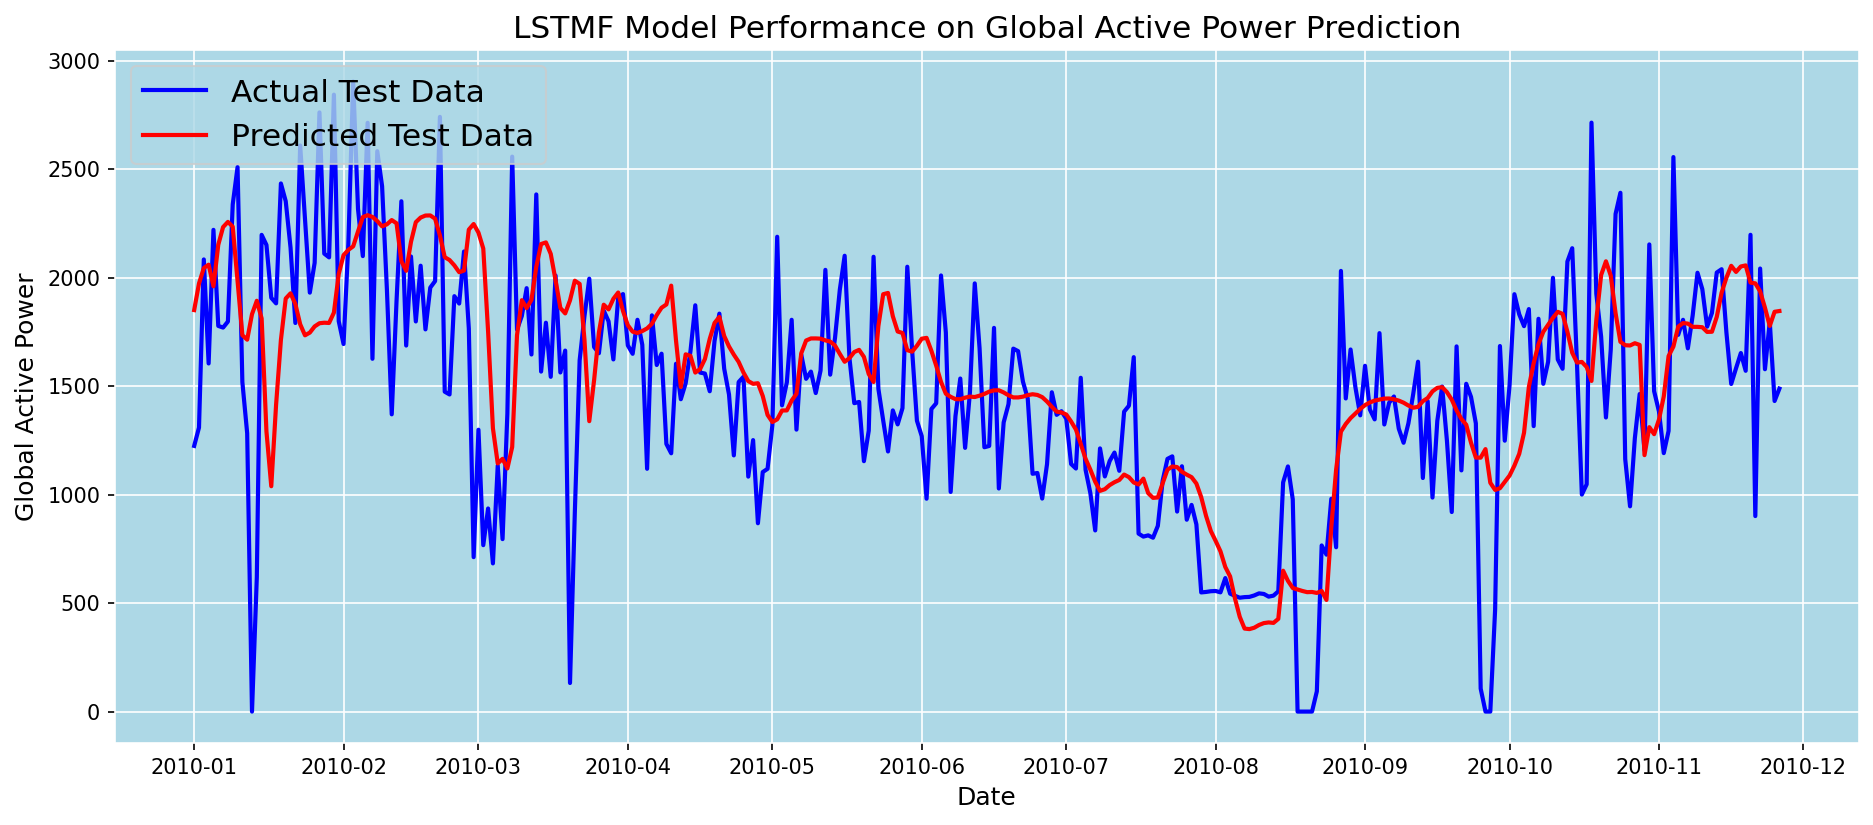

In [78]:
LSTMF_RMSE = validate_result(model, 'LSTMF')

### Sequential

In [79]:
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout (0.2) )
regressor.add(LSTM(units = 50, return_sequences = True) )
regressor.add(Dropout (0.2) )
regressor.add(LSTM(units = 50, return_sequences = True) )
regressor.add(Dropout (0.2))
regressor.add(LSTM(units = 50) )
regressor.add(Dropout (0.2))
regressor.add(Dense (units = 1))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

c:\Users\ALIENWARE\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [80]:
regressor.fit(X_train, y_train, epochs=150, batch_size=32)

Epoch 1/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - loss: 0.0379
Epoch 2/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0123
Epoch 3/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0137
Epoch 4/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0141
Epoch 5/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0118
Epoch 6/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0135
Epoch 7/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0122
Epoch 8/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0128
Epoch 9/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0111
Epoch 10/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0124
Epoch 11/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0127
Epoch 12/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0121
Epoch 13/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0120
Epoch 14/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0116
Epoch 15/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - lo

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step
LSTMS RMSE:  0.08204170651793519


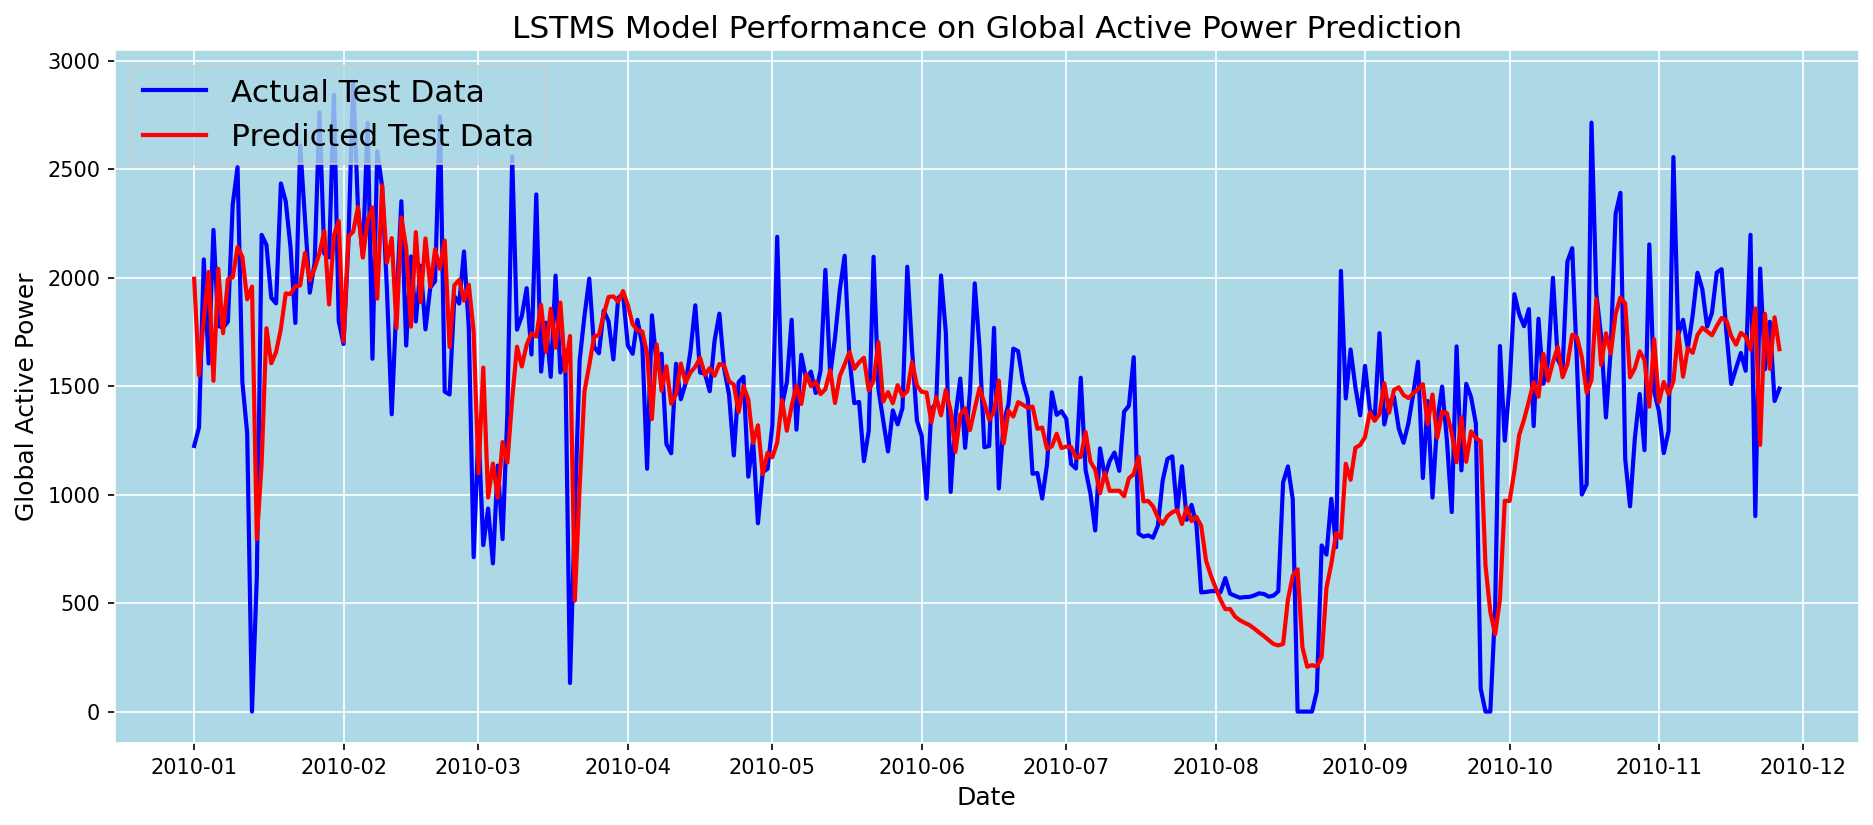

In [81]:
LSTMS_RMSE = validate_result(regressor, 'LSTMS')

## Performance Metrics

In [82]:
p_met = pd.DataFrame([ARIMA30_RMSE, ARIMA60_RMSE, LSTMF_RMSE, LSTMS_RMSE], index=['ARIMA 30DAYS', 'ARIMA 60DAYS', 'LSTM FUNCTIONAL', 'LSTM SEQUENTIAL'])

In [83]:
p_met = p_met.rename(columns={0: 'RMSE'})

In [87]:
p_met = p_met.drop(1, axis=1)

In [88]:
p_met

RMSE
ARIMA 30DAYS     0.109025
ARIMA 60DAYS     0.093142
LSTM FUNCTIONAL  0.091849
LSTM SEQUENTIAL  0.082042

Text(0, 0.5, 'RMSE')

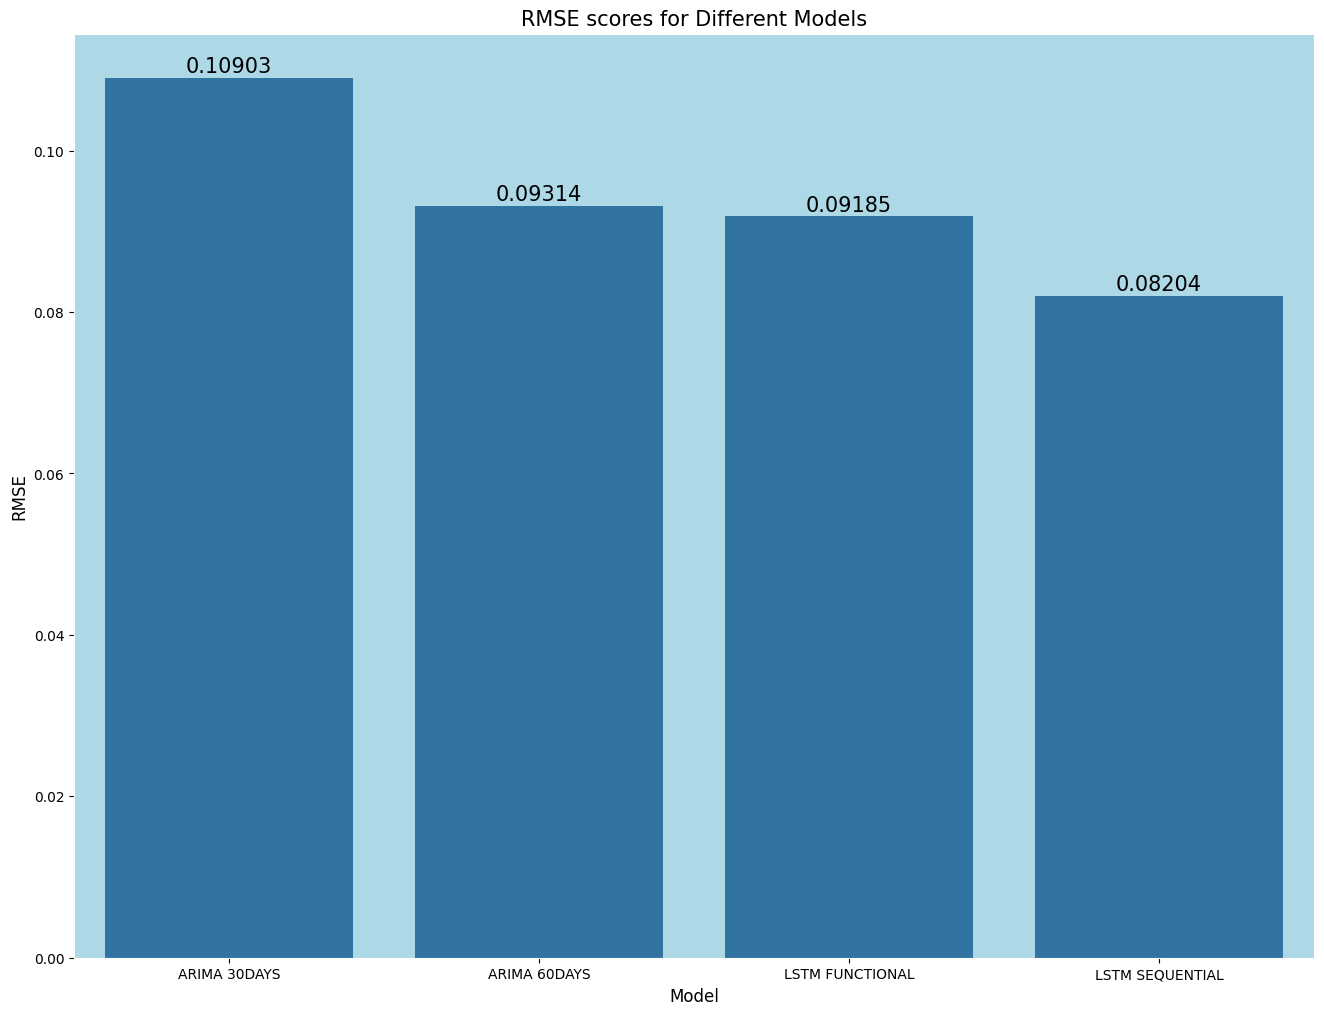

In [89]:
plots = sns.barplot( data=p_met, y="RMSE", x=p_met.index)

for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.5f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')
    
plt.title('RMSE scores for Different Models', fontsize=15)
plt.xlabel('Model', fontsize=12)
plt.ylabel('RMSE', fontsize=12)

## 4. Feature Engineering:

In [90]:
data.head(10)

Global_active_power  Global_reactive_power  Voltage  \
Datetime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   
2006-12-16 17:29:00                3.520                  0.522   235.02   
2006-12-16 17:30:00                3.702                  0.520   235.09   
2006-12-16 17:31:00                3.700                  0.520   235.22   
2006-12-16 17:32:00                3.668                  0.510   233.99   
2006-12-16 17:33:00                3.662                  0.510   233.86   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
Datetime                                                                
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00              15.8             0.0             1.0   
2006-12-16 17:29:00              15.0             0.0             2.0   
2006-12-16 17:30:00              15.8             0.0             1.0   
2006-12-16 17:31:00              15.8             0.0             1.0   
2006-12-16 17:32:00              15.8             0.0             1.0   
2006-12-16 17:33:00              15.8             0.0             2.0   

                     Sub_metering_3  
Datetime                             
2006-12-16 17:24:00            17.0  
2006-12-16 17:25:00            16.0  
2006-12-16 17:26:00            17.0  
2006-12-16 17:27:00            17.0  
2006-12-16 17:28:00            17.0  
2006-12-16 17:29:00            17.0  
2006-12-16 17:30:00            17.0  
2006-12-16 17:31:00            17.0  
2006-12-16 17:32:00            17.0  
2006-12-16 17:33:00            16.0

In [91]:
dat = data
dat

Global_active_power  Global_reactive_power  Voltage  \
Datetime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   
...                                  ...                    ...      ...   
2010-11-26 20:58:00                0.946                  0.000   240.43   
2010-11-26 20:59:00                0.944                  0.000   240.00   
2010-11-26 21:00:00                0.938                  0.000   239.82   
2010-11-26 21:01:00                0.934                  0.000   239.70   
2010-11-26 21:02:00                0.932                  0.000   239.55   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
Datetime                                                                
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00              15.8             0.0             1.0   
...                               ...             ...             ...   
2010-11-26 20:58:00               4.0             0.0             0.0   
2010-11-26 20:59:00               4.0             0.0             0.0   
2010-11-26 21:00:00               3.8             0.0             0.0   
2010-11-26 21:01:00               3.8             0.0             0.0   
2010-11-26 21:02:00               3.8             0.0             0.0   

                     Sub_metering_3  
Datetime                             
2006-12-16 17:24:00            17.0  
2006-12-16 17:25:00            16.0  
2006-12-16 17:26:00            17.0  
2006-12-16 17:27:00            17.0  
2006-12-16 17:28:00            17.0  
...                             ...  
2010-11-26 20:58:00             0.0  
2010-11-26 20:59:00             0.0  
2010-11-26 21:00:00             0.0  
2010-11-26 21:01:00             0.0  
2010-11-26 21:02:00             0.0  

[2049280 rows x 7 columns]

In [92]:
dat['Global_apparent_power'] = np.sqrt(((dat['Global_active_power'])**2)+((dat['Global_reactive_power'])**2))
dat['Power_factor'] = dat['Global_active_power']/dat['Global_apparent_power']

In [93]:
dat.head(10)

Global_active_power  Global_reactive_power  Voltage  \
Datetime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   
2006-12-16 17:29:00                3.520                  0.522   235.02   
2006-12-16 17:30:00                3.702                  0.520   235.09   
2006-12-16 17:31:00                3.700                  0.520   235.22   
2006-12-16 17:32:00                3.668                  0.510   233.99   
2006-12-16 17:33:00                3.662                  0.510   233.86   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
Datetime                                                                
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00              15.8             0.0             1.0   
2006-12-16 17:29:00              15.0             0.0             2.0   
2006-12-16 17:30:00              15.8             0.0             1.0   
2006-12-16 17:31:00              15.8             0.0             1.0   
2006-12-16 17:32:00              15.8             0.0             1.0   
2006-12-16 17:33:00              15.8             0.0             2.0   

                     Sub_metering_3  Global_apparent_power  Power_factor  
Datetime                                                                  
2006-12-16 17:24:00            17.0               4.236671      0.995121  
2006-12-16 17:25:00            16.0               5.377704      0.996708  
2006-12-16 17:26:00            17.0               5.397025      0.995734  
2006-12-16 17:27:00            17.0               5.411335      0.995688  
2006-12-16 17:28:00            17.0               3.703828      0.989787  
2006-12-16 17:29:00            17.0               3.558495      0.989182  
2006-12-16 17:30:00            17.0               3.738342      0.990278  
2006-12-16 17:31:00            17.0               3.736362      0.990268  
2006-12-16 17:32:00            17.0               3.703286      0.990472  
2006-12-16 17:33:00            16.0               3.697343      0.990441

In [94]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2049280 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
 7   Global_apparent_power  float64
 8   Power_factor           float64
dtypes: float64(9)
memory usage: 156.3 MB


In [95]:
dat.corr()['Global_active_power'].sort_values()

Voltage                 -0.399762
Global_reactive_power    0.247017
Power_factor             0.385414
Sub_metering_2           0.434569
Sub_metering_1           0.484401
Sub_metering_3           0.638555
Global_intensity         0.998889
Global_apparent_power    0.999708
Global_active_power      1.000000
Name: Global_active_power, dtype: float64

<Axes: >

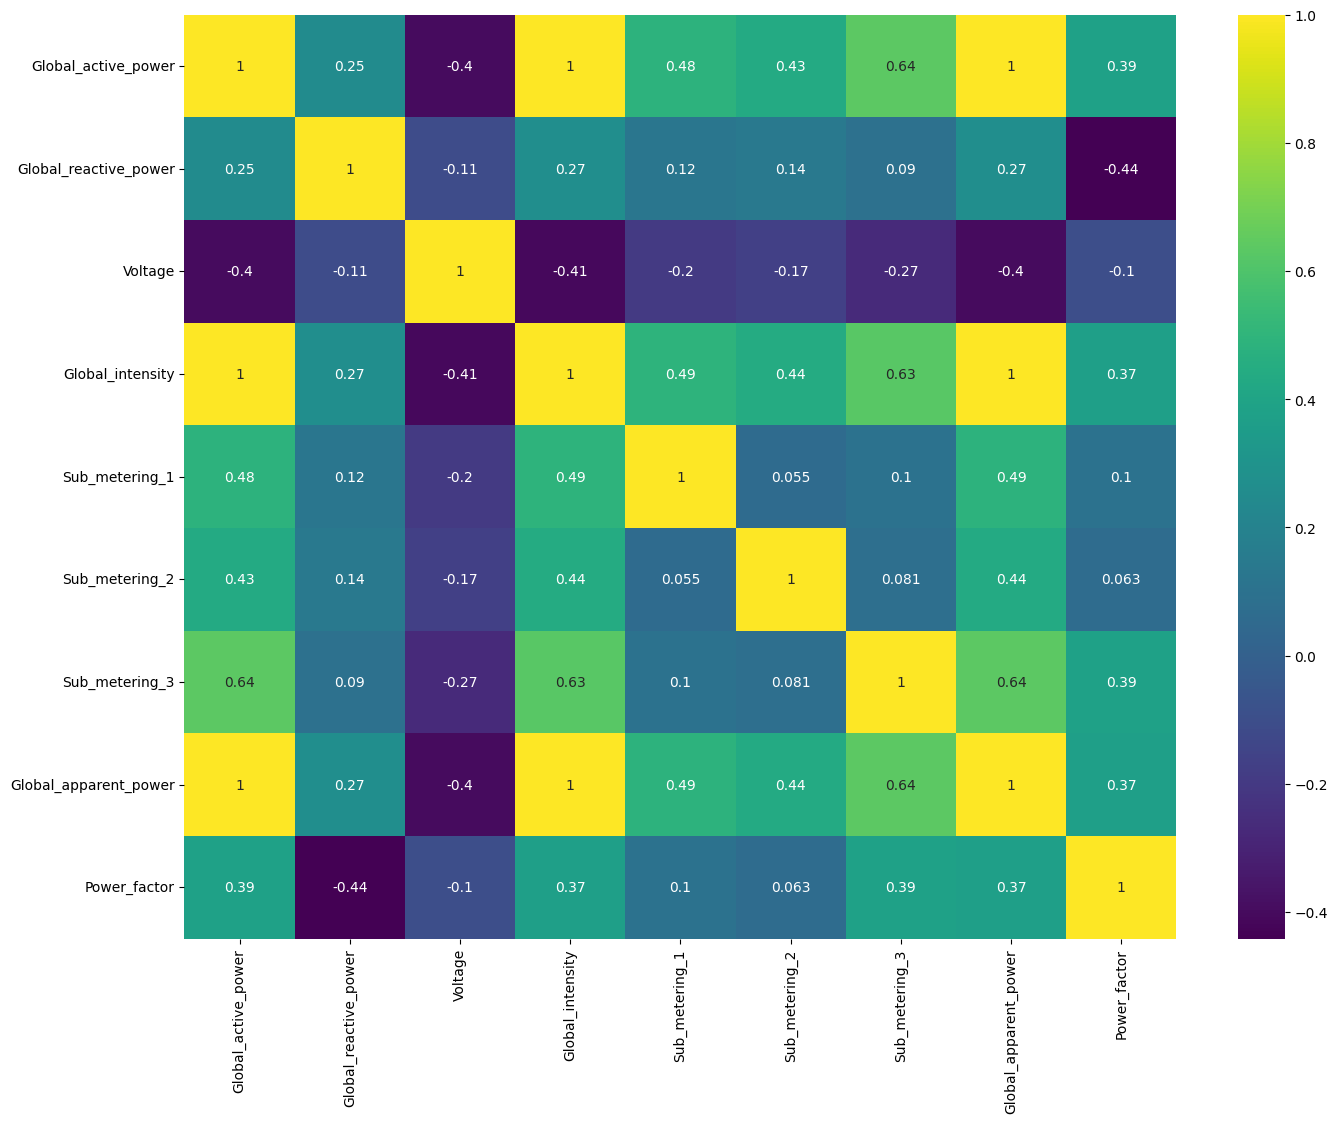

In [96]:
sns.heatmap(data=dat.corr(), annot=True, cmap='viridis')

In [97]:
train_data = dat[:-test_size]
test_data = dat[-test_size:]

In [98]:
train_data

Global_active_power  Global_reactive_power  Voltage  \
Datetime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   
...                                  ...                    ...      ...   
2010-11-26 15:28:00                1.272                  0.058   239.67   
2010-11-26 15:29:00                0.224                  0.046   241.11   
2010-11-26 15:30:00                0.330                  0.000   241.29   
2010-11-26 15:31:00                0.436                  0.084   241.32   
2010-11-26 15:32:00                0.432                  0.084   241.16   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
Datetime                                                                
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00              15.8             0.0             1.0   
...                               ...             ...             ...   
2010-11-26 15:28:00               5.2             0.0             0.0   
2010-11-26 15:29:00               1.0             0.0             0.0   
2010-11-26 15:30:00               1.4             0.0             0.0   
2010-11-26 15:31:00               1.8             0.0             0.0   
2010-11-26 15:32:00               1.8             0.0             0.0   

                     Sub_metering_3  Global_apparent_power  Power_factor  
Datetime                                                                  
2006-12-16 17:24:00            17.0               4.236671      0.995121  
2006-12-16 17:25:00            16.0               5.377704      0.996708  
2006-12-16 17:26:00            17.0               5.397025      0.995734  
2006-12-16 17:27:00            17.0               5.411335      0.995688  
2006-12-16 17:28:00            17.0               3.703828      0.989787  
...                             ...                    ...           ...  
2010-11-26 15:28:00            17.0               1.273322      0.998962  
2010-11-26 15:29:00             2.0               0.228674      0.979559  
2010-11-26 15:30:00             0.0               0.330000      1.000000  
2010-11-26 15:31:00             0.0               0.444018      0.981942  
2010-11-26 15:32:00             0.0               0.440091      0.981615  

[2048950 rows x 9 columns]

In [99]:
test_data

Global_active_power  Global_reactive_power  Voltage  \
Datetime                                                                   
2010-11-26 15:33:00                0.432                  0.086   241.90   
2010-11-26 15:34:00                0.516                  0.182   241.30   
2010-11-26 15:35:00                0.502                  0.188   240.93   
2010-11-26 15:36:00                0.500                  0.186   240.66   
2010-11-26 15:37:00                0.502                  0.184   240.03   
...                                  ...                    ...      ...   
2010-11-26 20:58:00                0.946                  0.000   240.43   
2010-11-26 20:59:00                0.944                  0.000   240.00   
2010-11-26 21:00:00                0.938                  0.000   239.82   
2010-11-26 21:01:00                0.934                  0.000   239.70   
2010-11-26 21:02:00                0.932                  0.000   239.55   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
Datetime                                                                
2010-11-26 15:33:00               1.8             0.0             0.0   
2010-11-26 15:34:00               2.2             0.0             0.0   
2010-11-26 15:35:00               2.2             0.0             0.0   
2010-11-26 15:36:00               2.2             0.0             0.0   
2010-11-26 15:37:00               2.2             0.0             0.0   
...                               ...             ...             ...   
2010-11-26 20:58:00               4.0             0.0             0.0   
2010-11-26 20:59:00               4.0             0.0             0.0   
2010-11-26 21:00:00               3.8             0.0             0.0   
2010-11-26 21:01:00               3.8             0.0             0.0   
2010-11-26 21:02:00               3.8             0.0             0.0   

                     Sub_metering_3  Global_apparent_power  Power_factor  
Datetime                                                                  
2010-11-26 15:33:00             0.0               0.440477      0.980755  
2010-11-26 15:34:00             0.0               0.547156      0.943058  
2010-11-26 15:35:00             0.0               0.536049      0.936482  
2010-11-26 15:36:00             0.0               0.533475      0.937250  
2010-11-26 15:37:00             0.0               0.534659      0.938917  
...                             ...                    ...           ...  
2010-11-26 20:58:00             0.0               0.946000      1.000000  
2010-11-26 20:59:00             0.0               0.944000      1.000000  
2010-11-26 21:00:00             0.0               0.938000      1.000000  
2010-11-26 21:01:00             0.0               0.934000      1.000000  
2010-11-26 21:02:00             0.0               0.932000      1.000000  

[330 rows x 9 columns]

In [100]:
X_train = train_data.drop('Global_active_power',axis=1)
y_train = train_data['Global_active_power']

In [101]:
X_test = test_data.drop('Global_active_power',axis=1)
y_test = test_data['Global_active_power']

In [102]:
X_train

Global_reactive_power  Voltage  Global_intensity  \
Datetime                                                                
2006-12-16 17:24:00                  0.418   234.84              18.4   
2006-12-16 17:25:00                  0.436   233.63              23.0   
2006-12-16 17:26:00                  0.498   233.29              23.0   
2006-12-16 17:27:00                  0.502   233.74              23.0   
2006-12-16 17:28:00                  0.528   235.68              15.8   
...                                    ...      ...               ...   
2010-11-26 15:28:00                  0.058   239.67               5.2   
2010-11-26 15:29:00                  0.046   241.11               1.0   
2010-11-26 15:30:00                  0.000   241.29               1.4   
2010-11-26 15:31:00                  0.084   241.32               1.8   
2010-11-26 15:32:00                  0.084   241.16               1.8   

                     Sub_metering_1  Sub_metering_2  Sub_metering_3  \
Datetime                                                              
2006-12-16 17:24:00             0.0             1.0            17.0   
2006-12-16 17:25:00             0.0             1.0            16.0   
2006-12-16 17:26:00             0.0             2.0            17.0   
2006-12-16 17:27:00             0.0             1.0            17.0   
2006-12-16 17:28:00             0.0             1.0            17.0   
...                             ...             ...             ...   
2010-11-26 15:28:00             0.0             0.0            17.0   
2010-11-26 15:29:00             0.0             0.0             2.0   
2010-11-26 15:30:00             0.0             0.0             0.0   
2010-11-26 15:31:00             0.0             0.0             0.0   
2010-11-26 15:32:00             0.0             0.0             0.0   

                     Global_apparent_power  Power_factor  
Datetime                                                  
2006-12-16 17:24:00               4.236671      0.995121  
2006-12-16 17:25:00               5.377704      0.996708  
2006-12-16 17:26:00               5.397025      0.995734  
2006-12-16 17:27:00               5.411335      0.995688  
2006-12-16 17:28:00               3.703828      0.989787  
...                                    ...           ...  
2010-11-26 15:28:00               1.273322      0.998962  
2010-11-26 15:29:00               0.228674      0.979559  
2010-11-26 15:30:00               0.330000      1.000000  
2010-11-26 15:31:00               0.444018      0.981942  
2010-11-26 15:32:00               0.440091      0.981615  

[2048950 rows x 8 columns]

In [103]:
from sklearn.tree import DecisionTreeRegressor

In [104]:
dtr = DecisionTreeRegressor()

In [105]:
dtr.fit(X_train,y_train)

DecisionTreeRegressor()

In [106]:
y_pred = dtr.predict(X_test)

In [107]:
np.sqrt(mean_squared_error(y_test, y_pred))

0.0003813850356982408

In [108]:
dtr.feature_importances_

array([2.57573829e-06, 3.95290236e-08, 2.71382403e-04, 1.16628356e-08,
       1.56805820e-08, 1.43272427e-08, 9.99310423e-01, 4.15538100e-04])

In [109]:
pd.DataFrame(index=X_train.columns,data=dtr.feature_importances_,columns=['Feature Importance']).sort_values(by='Feature Importance', ascending=False)

Feature Importance
Global_apparent_power        9.993104e-01
Power_factor                 4.155381e-04
Global_intensity             2.713824e-04
Global_reactive_power        2.575738e-06
Voltage                      3.952902e-08
Sub_metering_2               1.568058e-08
Sub_metering_3               1.432724e-08
Sub_metering_1               1.166284e-08

## 5. Future Consumption Prediction:

### ARIMA

In [110]:
X_train, X_test, y_train, y_test = data_arima(30)

In [112]:
X_new = arima30.predict(330, X_test)

In [113]:
X_next=[]

for i in range(30, len(X_new)):
        X_next.append(X_new[i-30:i])
        

In [114]:
X_test.shape

(330, 30)

In [115]:
X_next= np.array(X_next)

In [116]:
y_next = arima30.predict(300, X_next)

In [117]:
y_next = np.reshape(y_next, (-1,1))
y_next_pred = scaler.inverse_transform(y_next)

In [118]:
daily_data.index[-1]

Timestamp('2010-11-26 00:00:00')

In [119]:
import datetime

num_of_dates = 300
start = daily_data.index[-1]
date_list = [start.date() + datetime.timedelta(days=x) for x in range(num_of_dates)]
print('Next 3 days starting from today')
print(date_list)


Next 3 days starting from today
[datetime.date(2010, 11, 26), datetime.date(2010, 11, 27), datetime.date(2010, 11, 28), datetime.date(2010, 11, 29), datetime.date(2010, 11, 30), datetime.date(2010, 12, 1), datetime.date(2010, 12, 2), datetime.date(2010, 12, 3), datetime.date(2010, 12, 4), datetime.date(2010, 12, 5), datetime.date(2010, 12, 6), datetime.date(2010, 12, 7), datetime.date(2010, 12, 8), datetime.date(2010, 12, 9), datetime.date(2010, 12, 10), datetime.date(2010, 12, 11), datetime.date(2010, 12, 12), datetime.date(2010, 12, 13), datetime.date(2010, 12, 14), datetime.date(2010, 12, 15), datetime.date(2010, 12, 16), datetime.date(2010, 12, 17), datetime.date(2010, 12, 18), datetime.date(2010, 12, 19), datetime.date(2010, 12, 20), datetime.date(2010, 12, 21), datetime.date(2010, 12, 22), datetime.date(2010, 12, 23), datetime.date(2010, 12, 24), datetime.date(2010, 12, 25), datetime.date(2010, 12, 26), datetime.date(2010, 12, 27), datetime.date(2010, 12, 28), datetime.date(2010,

Text(0.5, 1.0, 'Global Active Power Prediction for the next 300 days (ARIMA)')

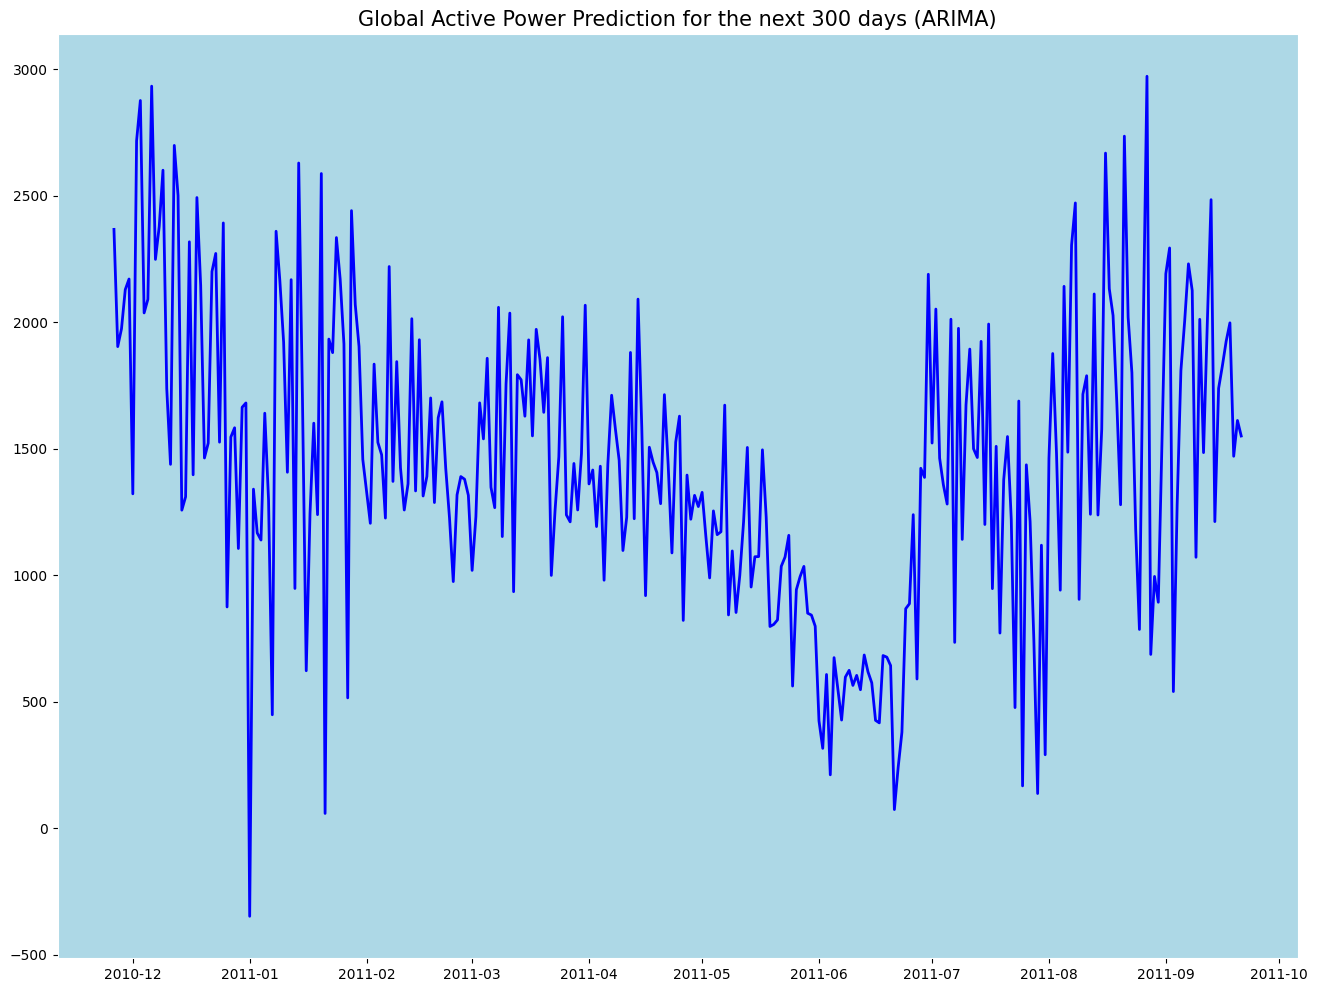

In [120]:
plt.plot(date_list, y_next_pred, color='blue', lw=2)
plt.title('Global Active Power Prediction for the next 300 days (ARIMA)', fontsize=15)

### FUNCTIONAL LSTM

In [121]:
X_train, X_test, y_train, y_test = data_lstm(30)

In [122]:
X_train.shape

(1082, 30, 1)

In [123]:
X_new = model.predict(X_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [124]:
X_next=[]

for i in range(30, len(X_new)):
        X_next.append(X_new[i-30:i])
        

In [125]:
X_test.shape

(330, 30, 1)

In [126]:
X_next= np.array(X_next)

In [127]:
y_next = model.predict(X_next)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [128]:
y_next.shape

(300, 1)

In [129]:
y_next = np.reshape(y_next, (-1,1))
y_next_pred = scaler.inverse_transform(y_next)

Text(0, 0.5, 'Global Active Power')

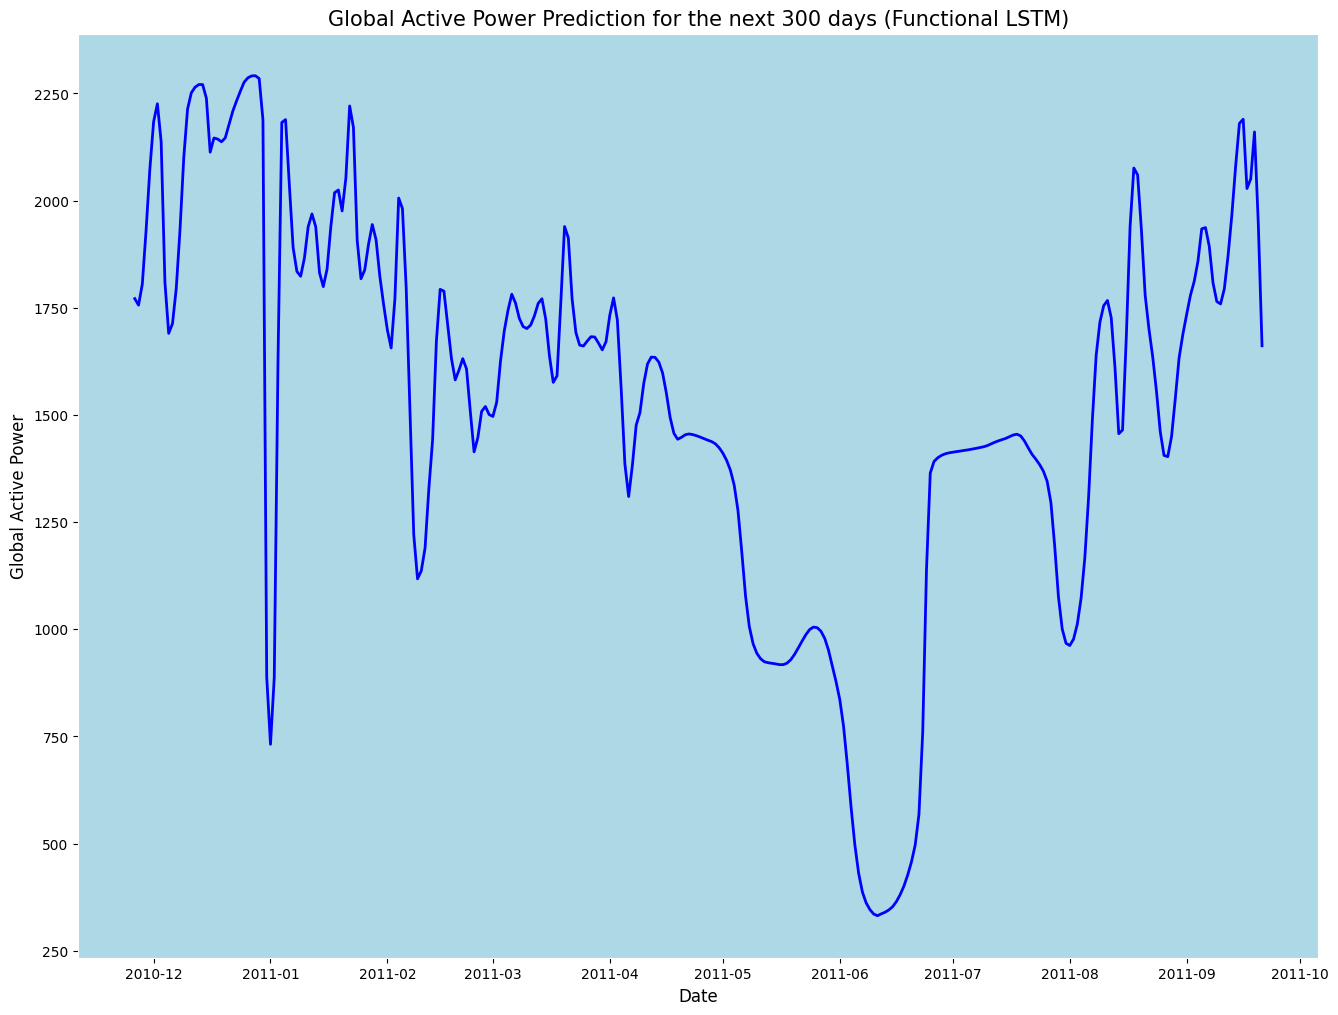

In [130]:
plt.plot(date_list, y_next_pred, color='blue', lw=2)
plt.title('Global Active Power Prediction for the next 300 days (Functional LSTM)', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Global Active Power', fontsize=12)

### SEQUENTIAL LSTM

In [131]:
X_train, X_test, y_train, y_test = data_lstm(30)

In [132]:
X_train.shape

(1082, 30, 1)

In [133]:
X_new = regressor.predict(X_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [134]:
X_next=[]

for i in range(30, len(X_new)):
        X_next.append(X_new[i-30:i])
        

In [135]:
X_test.shape

(330, 30, 1)

In [136]:
X_next= np.array(X_next)

In [137]:
y_next = regressor.predict(X_next)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [138]:
y_next.shape

(300, 1)

In [139]:
y_next = np.reshape(y_next, (-1,1))
y_next_pred = scaler.inverse_transform(y_next)

Text(0, 0.5, 'Global Active Power')

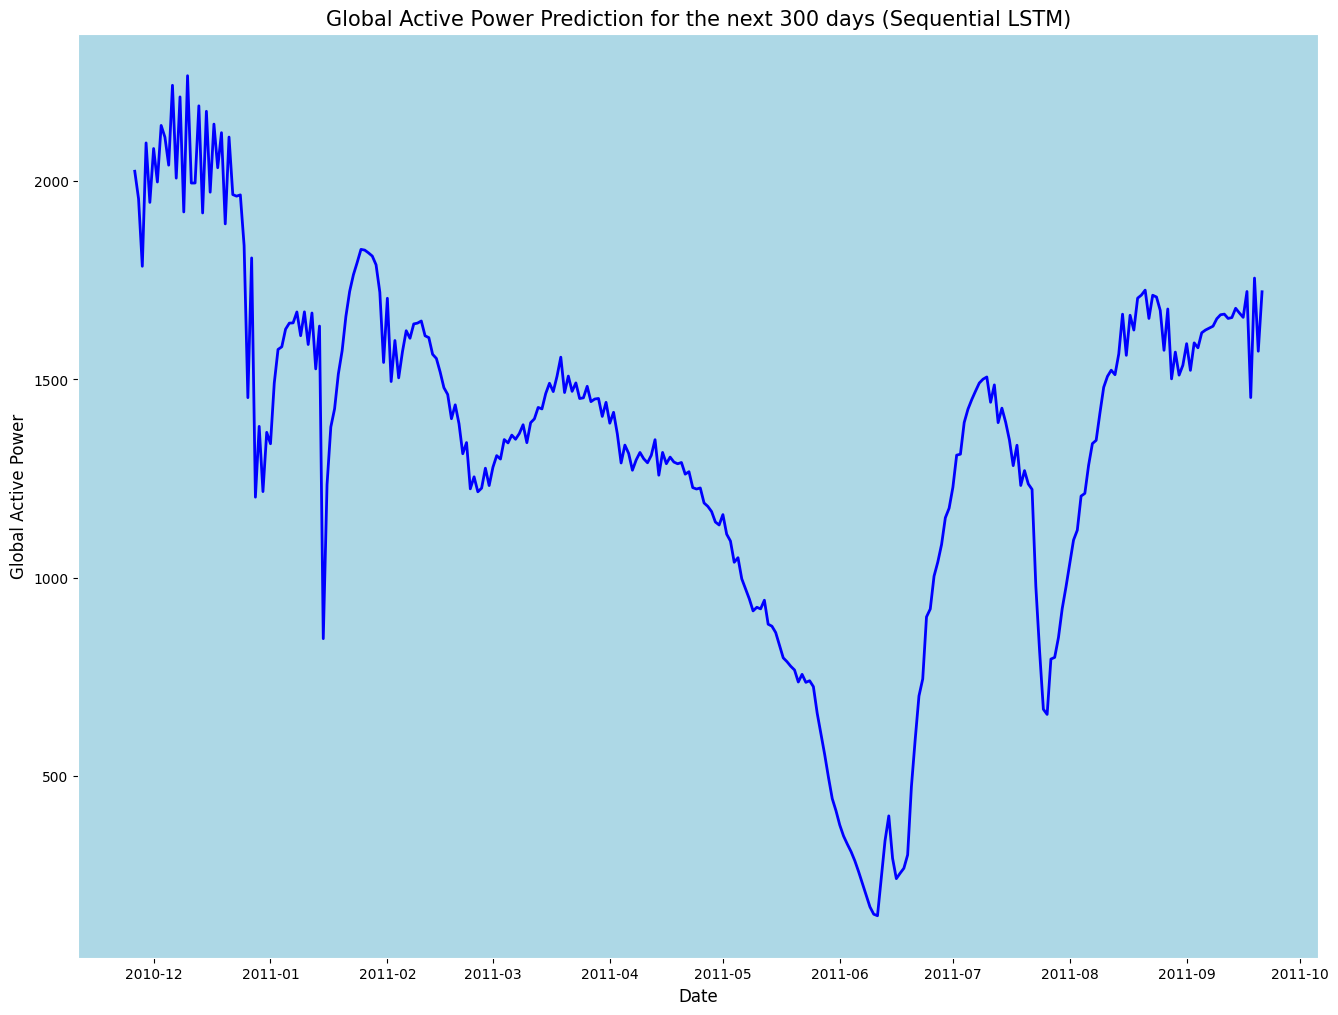

In [140]:
plt.plot(date_list, y_next_pred, color='blue', lw=2)
plt.title('Global Active Power Prediction for the next 300 days (Sequential LSTM)', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Global Active Power', fontsize=12)